In [1]:
import sys, os, gzip, shutil
import datetime as dt
import pandas as pd
import geopandas as gp
import numpy as np
import holidays
from shapely.geometry import Point
import matplotlib.pyplot as plt
pd.set_option('max_columns', None)
import warnings
warnings.filterwarnings("ignore")

# Definitions

In [2]:
# Area and facility type dictionaries
area_types = {0: 'Regional Core', 
              1: 'CBD', 
              2: 'Urban Business', 
              3: 'Urban',  
              4: 'Suburban', 
              5: 'Rural'}
facility_types = {1: 'Fwy-Fwy Connector', 2: 'Freeway', 3: 'Expressway', 4: 'Collector', 5: 'Ramp', 
                  6: 'Centroid Connector', 7: 'Major Arterial', 9: 'Alley', 10: 'Metered Ramp', 11: 'Local', 
                  12: 'Minor Arterial', 13: 'Bike-Only!', 15: 'Super Arterial'}

In [3]:
# DIRs and Input Files
vdf_dir =  r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF'

champ_dir = r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF\champ_hwy_shapefile'
champ_file = 'freeflow.shp'

#Arterials
arterial_adt_dir = vdf_dir
arterial_adt_file = 'CMP_ADT_Counts.xlsx'
adt_stations_match = 'adt_stations_champ_inrix_xdsegs.csv' # ADT stations matched with CHAMP and INRIX segment IDs

speed_dir = r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF\INRIX_Speeds'
arterial_speed_files = [['vdf_segments_2021-05-04_to_2021-05-10_1_min_part_', 1]]
ramp_speed_files = [['vdf_ramps_2021-04-01_to_2021-05-16_1_min_part_', 1]]

#Freeways
pems_dir = r'D:\PeMS'
pems_stations = 'D4_Data_2021\station_meta\d04_text_meta_2021_03_19.txt'
pems_stations_champ = 'd04_stations_sf.csv'

In [4]:
# Define percentile funtion to get different percentile speeds
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [5]:
champ = gp.read_file(os.path.join(champ_dir, champ_file))

# Arterials

## Processing Data 

In [6]:
adt_sta = pd.read_excel(os.path.join(arterial_adt_dir, arterial_adt_file), sheet_name='Count_locations')
adt_cnts = pd.read_excel(os.path.join(arterial_adt_dir, arterial_adt_file), sheet_name='15min_data')
adt_cnts['rDate']=pd.to_datetime(adt_cnts['Date'])
epochs = pd.read_excel(os.path.join(arterial_adt_dir, arterial_adt_file), sheet_name='Timep_map')
epochs.insert(0, 'Epoch', range(0, len(epochs)))  # insert 15-min epoch

In [7]:
champ_with_adt_stations = pd.read_csv(os.path.join(vdf_dir, adt_stations_match))

In [8]:
adt_cnts = pd.merge(adt_cnts, epochs, left_on='Time', right_on='Time_interval', how='left')
adt_cnts = pd.merge(adt_cnts, champ_with_adt_stations[['CHAMP_link', 'XDSegID']], left_on='AT', right_on='CHAMP_link', how='left')

In [9]:
adt_cols = ['ID', 'Direction', 'Year', 'Date', 'Time', 'Vol', 'TP', 'ID_Dir', 
            'rDate', 'Epoch', 'Time_interval', 'Time_period', 'CHAMP_link', 'XDSegID']
champ_cols = ['AB', 'USE', 'CAP', 'AT', 'FT', 'SPEED', 'DISTANCE', 'TIME', 'LANE_AM', 'LANE_OP', 'LANE_PM']
adt_cnts = adt_cnts[adt_cols].merge(champ[champ_cols],  left_on='CHAMP_link', right_on= 'AB', how='left')

In [12]:
for p in arterial_speed_files:
    df_speed = pd.read_csv(os.path.join(speed_dir, '%s%s\data.csv' %(p[0],p[1])))

In [13]:
df_speed.rename(columns={'Segment ID':'XDSegID', 'Speed(miles/hour)':'speed'}, inplace=True)
df_speed['Date_Time'] = df_speed['Date Time'].str[:19]
df_speed['Date_Time'] = df_speed['Date_Time'].str.replace('T', " ")
df_speed['Date'] = df_speed['Date_Time'].str[:10]
df_speed['rDate']=pd.to_datetime(df_speed['Date'])
df_speed['Hour']= df_speed['Date_Time'].str[11:13]
df_speed['Minute']= df_speed['Date_Time'].str[14:16]
df_speed['Epoch']= df_speed['Hour'].astype(int) * 4 + df_speed['Minute'].astype(int)//15  # convert each minute to 15-min epoch

In [14]:
grpby_cols = ['XDSegID', 'rDate', 'Epoch']
df_speed_15min = df_speed.groupby(grpby_cols).agg({'speed':['mean', 'count']}).reset_index()
df_speed_15min.columns = grpby_cols + ['speed', 'Numof1Minutes']

In [15]:
adt_cnts_speeds = pd.merge(adt_cnts, df_speed_15min, on=['XDSegID', 'rDate', 'Epoch'], how='left')

In [17]:
adt_cnts_speeds['hourly_volume'] = adt_cnts_speeds['Vol'] * 4 
adt_cnts_speeds['hourly_volume_per_lane'] = np.where(adt_cnts_speeds['Time_period']=='1_AM',
                                        adt_cnts_speeds['hourly_volume'] / adt_cnts_speeds['LANE_AM'],
                                        np.where(adt_cnts_speeds['Time_period']=='3_PM',
                                                adt_cnts_speeds['hourly_volume'] / adt_cnts_speeds['LANE_PM'],
                                                adt_cnts_speeds['hourly_volume'] / adt_cnts_speeds['LANE_OP']))
adt_cnts_speeds['density'] = adt_cnts_speeds['hourly_volume_per_lane'] / adt_cnts_speeds['speed']

In [18]:
adt_cnts_speeds_notnan = adt_cnts_speeds[pd.notnull(adt_cnts_speeds['speed'])]

In [19]:
# Change facility type and capacity at 3 stations
adt_cnts_speeds_notnan['FTrev'] = np.where(adt_cnts_speeds_notnan['ID_Dir']=='11_NB', 7, 
                                           np.where(adt_cnts_speeds_notnan['ID_Dir']=='11_SB', 3, 
                                                    np.where(adt_cnts_speeds_notnan['ID_Dir']=='14_NB', 7,
                                                             adt_cnts_speeds_notnan['FT'])))
adt_cnts_speeds_notnan['CAPrev'] = np.where(adt_cnts_speeds_notnan['ID_Dir']=='11_NB', 950, 
                                           np.where(adt_cnts_speeds_notnan['ID_Dir']=='11_SB', 1450, 
                                                    np.where(adt_cnts_speeds_notnan['ID_Dir']=='14_NB', 950,
                                                             adt_cnts_speeds_notnan['CAP'])))

In [20]:
# Obtain speed distributions by FT and AT
arterials_ptiles = adt_cnts_speeds_notnan.groupby(['FTrev', 'AT']).agg({'speed': [percentile(25), percentile(50), 'mean', percentile(75), 
                                                          percentile(85), percentile(95), percentile(99)]}).reset_index()
arterials_ptiles.columns = ['FT', 'AT', 'pcnt25', 'pcnt50', 'mean', 'pcnt75', 'pcnt85', 'pcnt95', 'pcnt99']
arterials_ptiles

FT  AT     pcnt25     pcnt50       mean     pcnt75     pcnt85     pcnt95  \
0   3   2  35.933333  38.600000  38.560761  41.508333  42.666667  45.206667   
1   3   3  42.133333  44.833333  44.934665  47.333333  48.733333  52.470000   
2   7   0  11.266667  14.266667  14.586482  17.666667  19.600000  22.800000   
3   7   1  13.450000  16.800000  17.125931  20.733333  22.666667  26.000000   
4   7   2  14.400000  20.733333  22.379807  30.000000  34.148571  39.533333   
5   7   3  19.000000  24.666667  25.229094  30.407143  33.133333  43.466667   
6  12   0   9.266667  11.600000  11.855980  14.000000  15.266667  17.600000   
7  12   1  10.733333  12.333333  12.640360  14.400000  15.733333  18.071795   
8  15   0  13.866667  17.400000  17.309728  20.466667  22.466667  25.933333   
9  15   1  14.400000  17.666667  18.045641  21.066667  23.133333  26.082500   

      pcnt99  
0  48.400000  
1  55.472000  
2  27.478667  
3  30.047333  
4  43.243000  
5  51.800000  
6  21.333333  
7  23.000000  
8  31.576000  
9  29.877333

## Scatter Plots 

### All Stations Combined 

In [22]:
def flow_scatter(df, col_flow, col_speed, col_density):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    ax1.scatter(x = df[col_flow], y = df[col_speed], c='black', marker='+', s = 1)
    ax1.set_xlabel('flow')
    ax1.set_ylabel('speed')

    ax2.scatter(x = df[col_density], y = df[col_speed], c='black', marker='+', s = 1)
    ax2.set_xlabel('density')
    ax2.set_ylabel('speed')

    ax3.scatter(x = df[col_density], y = df[col_flow], c='black', marker='+', s = 1)
    ax3.set_xlabel('density')
    ax3.set_ylabel('flow')
    plt.show()

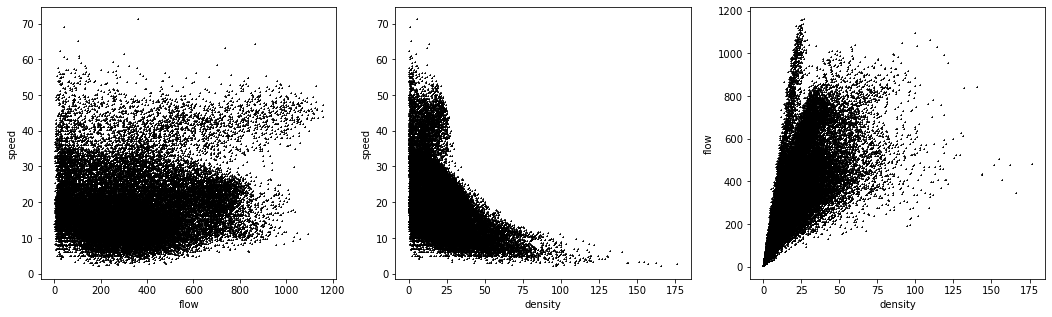

In [23]:
flow_scatter(adt_cnts_speeds_notnan, col_flow ='hourly_volume_per_lane', col_speed= 'speed', col_density = 'density')

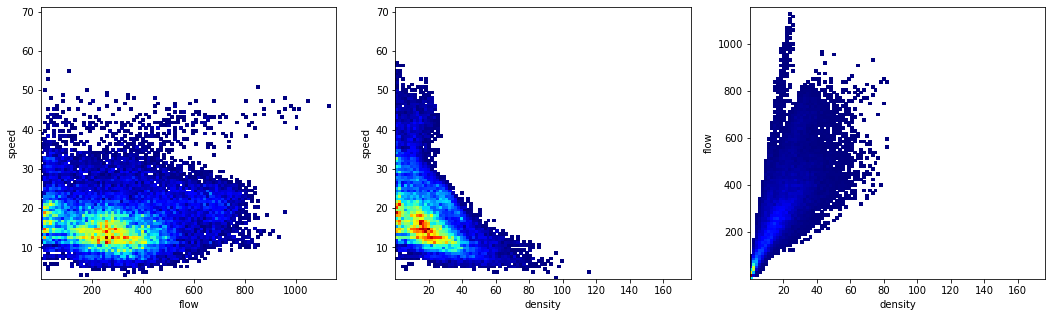

In [24]:
df, col_flow, col_speed, col_density = adt_cnts_speeds_notnan, 'hourly_volume_per_lane', 'speed', 'density'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.hist2d(df[col_flow], df[col_speed], (100, 100), cmin=3, cmap=plt.cm.jet)
ax1.set_xlabel('flow')
ax1.set_ylabel('speed')

ax2.hist2d(df[col_density], df[col_speed], (100, 100), cmin=3, cmap=plt.cm.jet)
ax2.set_xlabel('density')
ax2.set_ylabel('speed')

ax3.hist2d(df[col_density], df[col_flow], (100, 100), cmin=3, cmap=plt.cm.jet)
ax3.set_xlabel('density')
ax3.set_ylabel('flow')
plt.show()

### By Facility Types 

In [25]:
adt_cnts_speeds_notnan.drop_duplicates(['AT', 'FTrev', 'ID_Dir']).groupby(['FTrev']).ID_Dir.count()

FTrev
3      2
7     28
12     6
15     6
Name: ID_Dir, dtype: int64

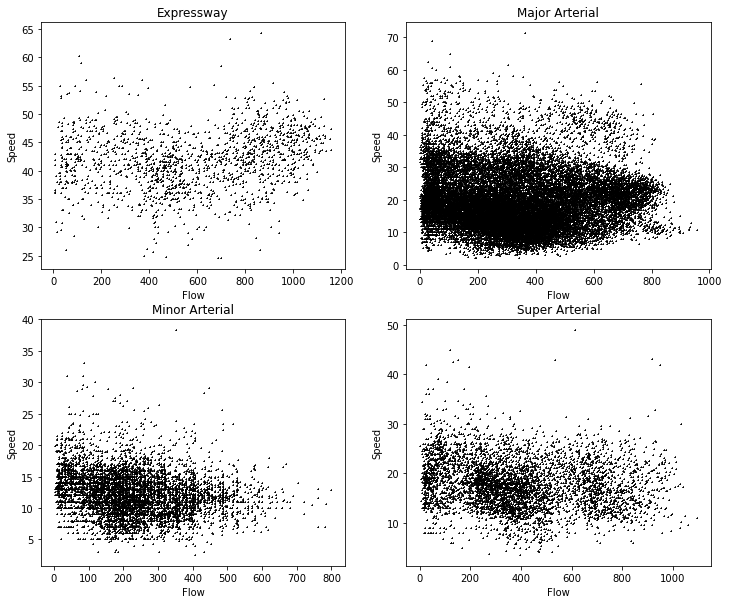

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
subid = 0
for ft in facility_types.keys():
    grp_speed = adt_cnts_speeds_notnan[(adt_cnts_speeds_notnan['FTrev']==ft)]
    if len(grp_speed)>0:
        row, col = subid//2, subid%2
        ax[row, col].scatter(x = grp_speed['hourly_volume_per_lane'], y = grp_speed['speed'], c='black', marker='+', s = 1)
        ax[row, col].set_xlabel('Flow')
        ax[row, col].set_ylabel('Speed')
        ax[row, col].set_title(facility_types[ft])
        subid += 1

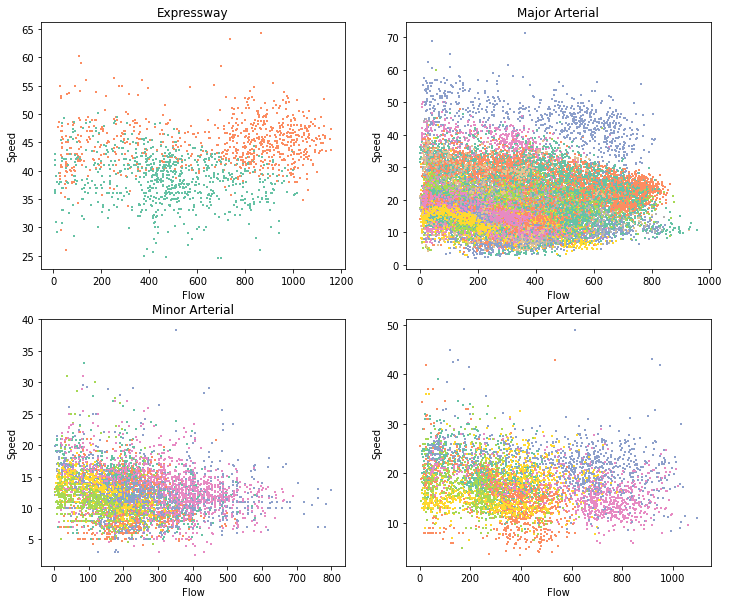

In [30]:
# Different color by stations 
fig, ax = plt.subplots(2, 2, figsize=(12,10))
subid = 0
for ft in facility_types.keys():
    grp_speed = adt_cnts_speeds_notnan[(adt_cnts_speeds_notnan['FTrev']==ft)]
    if len(grp_speed)>0:
        row, col = subid//2, subid%2
        color_labels = grp_speed['ID_Dir'].unique()
        rgb_values = sns.color_palette("Set2", len(color_labels))
        color_map = dict(zip(color_labels, rgb_values))
        ax[row, col].scatter(x = grp_speed['hourly_volume_per_lane'], y = grp_speed['speed'], 
                             c=grp_speed['ID_Dir'].map(color_map), marker='+', s = 4)
        ax[row, col].set_xlabel('Flow')
        ax[row, col].set_ylabel('Speed')
        ax[row, col].set_title(facility_types[ft])
        subid += 1

### By Area and Facility Types 

In [27]:
adt_cnts_speeds_notnan.drop_duplicates(['FTrev', 'AT', 'ID_Dir']).groupby(['FTrev', 'AT']).ID_Dir.count()

FTrev  AT
3      2      1
       3      1
7      0     10
       1      8
       2      3
       3      7
12     0      4
       1      2
15     0      2
       1      4
Name: ID_Dir, dtype: int64

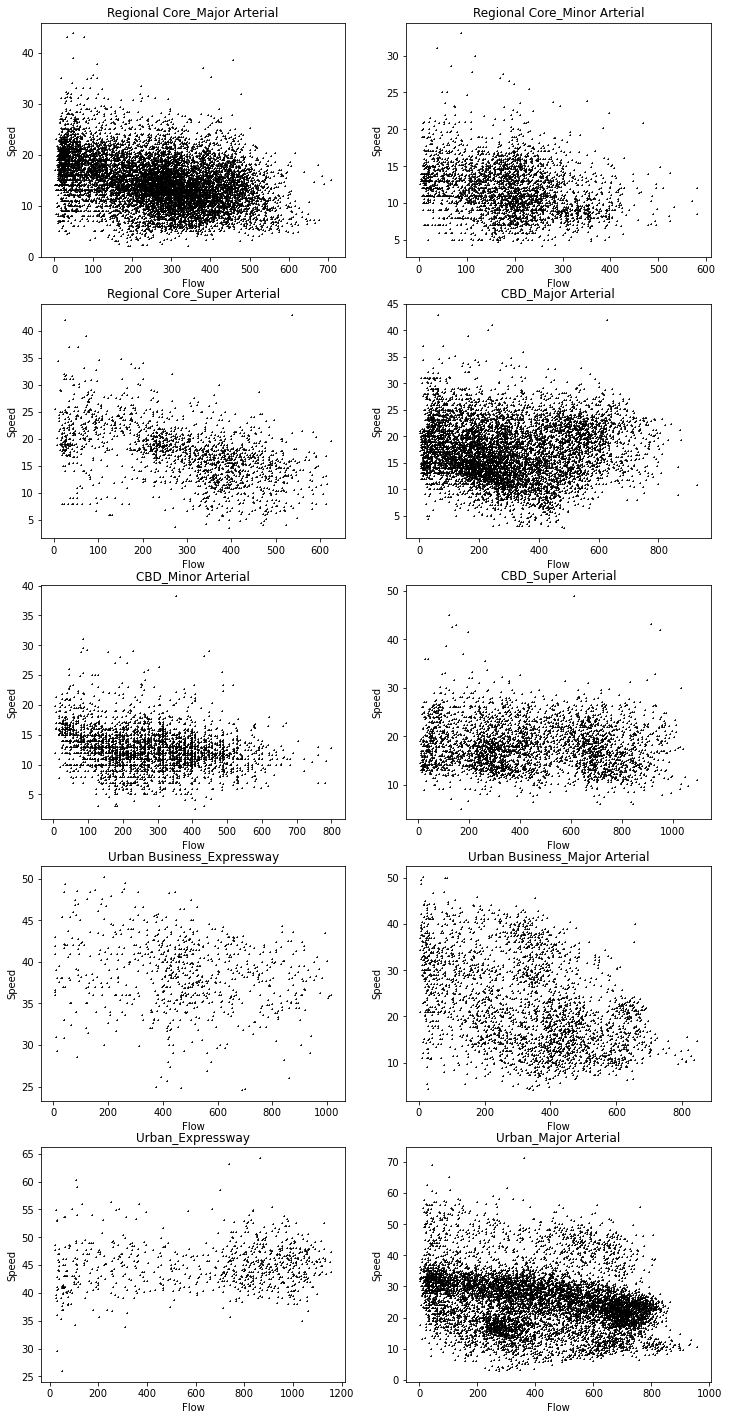

In [28]:
fig, ax = plt.subplots(5, 2, figsize=(12,25))
subid = 0
for at in area_types.keys():
    for ft in facility_types.keys():
        grp_speed = adt_cnts_speeds_notnan[(adt_cnts_speeds_notnan['AT']==at) & (adt_cnts_speeds_notnan['FTrev']==ft)]
        if len(grp_speed)>0:
            row, col = subid//2, subid%2
            ax[row, col].scatter(x = grp_speed['hourly_volume_per_lane'], y = grp_speed['speed'], c='black', marker='+', s = 1)
            ax[row, col].set_xlabel('Flow')
            ax[row, col].set_ylabel('Speed')
            ax[row, col].set_title(area_types[at] + '_' + facility_types[ft])
            subid += 1

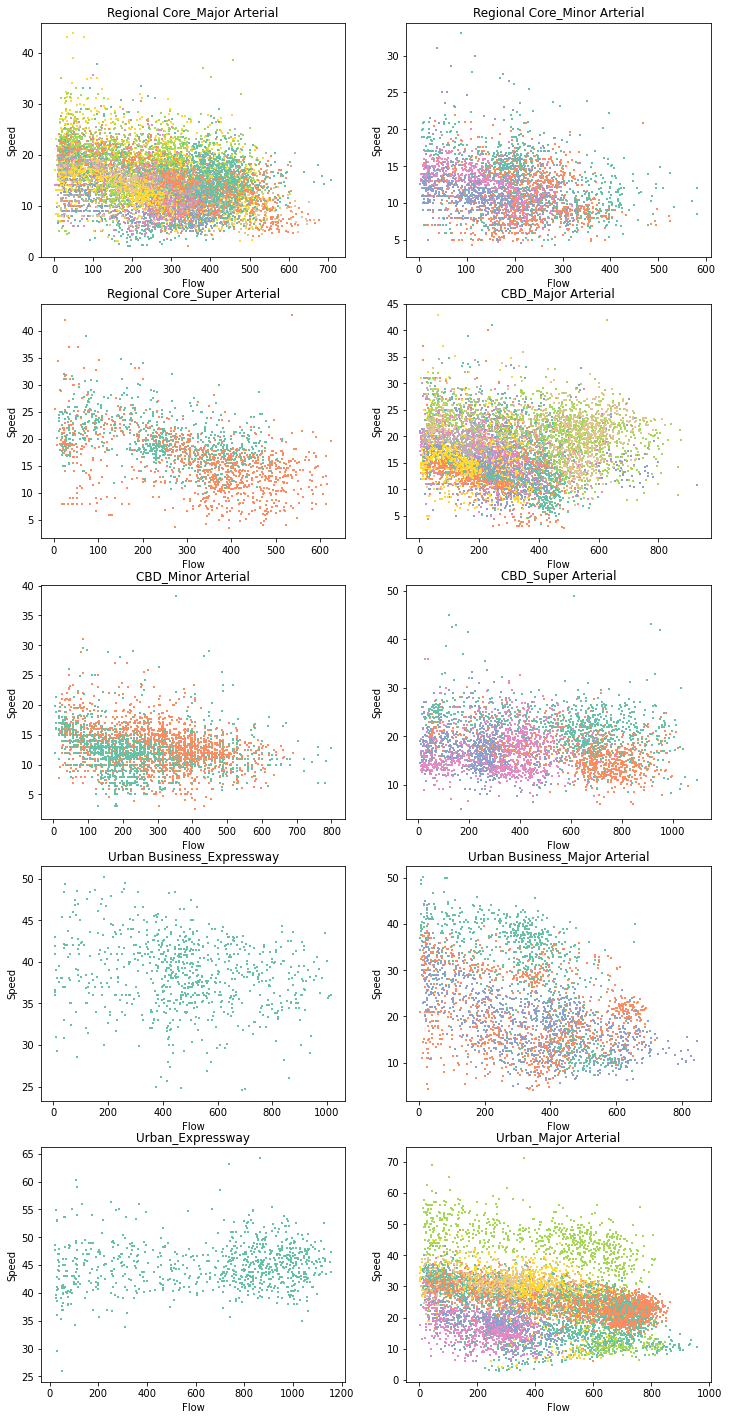

In [29]:
import seaborn as sns
fig, ax = plt.subplots(5, 2, figsize=(12,25))
subid = 0
for at in area_types.keys():
    for ft in facility_types.keys():
        grp_speed = adt_cnts_speeds_notnan[(adt_cnts_speeds_notnan['AT']==at) & (adt_cnts_speeds_notnan['FTrev']==ft)]
        if len(grp_speed)>0:
            row, col = subid//2, subid%2
            color_labels = grp_speed['ID_Dir'].unique()
            rgb_values = sns.color_palette("Set2", len(color_labels))
            color_map = dict(zip(color_labels, rgb_values))
            ax[row, col].scatter(x = grp_speed['hourly_volume_per_lane'], y = grp_speed['speed'], 
                                 c=grp_speed['ID_Dir'].map(color_map), marker='+', s = 4)
            ax[row, col].set_xlabel('Flow')
            ax[row, col].set_ylabel('Speed')
            ax[row, col].set_title(area_types[at] + '_' + facility_types[ft])
            subid += 1

### By Individual Station 

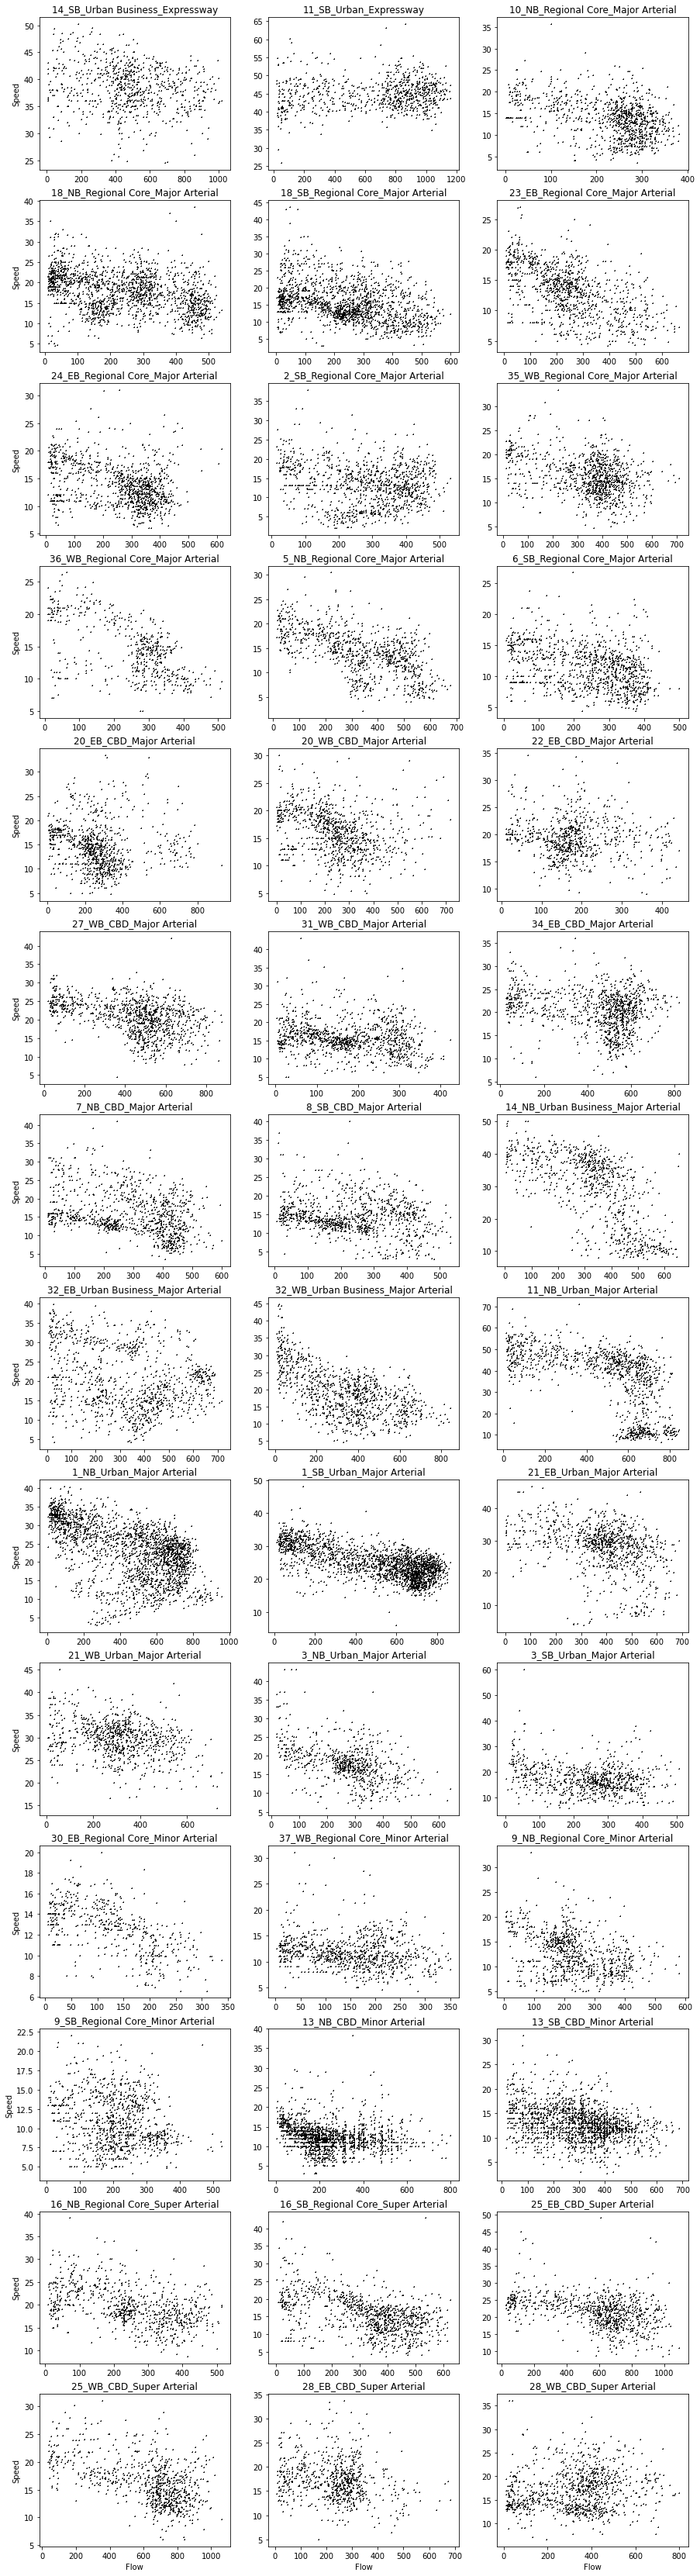

In [31]:
fig, ax = plt.subplots(14, 3, figsize=(15,60))
segs = adt_cnts_speeds_notnan.sort_values(by=['FTrev', 'AT', 'ID_Dir']).ID_Dir.unique().tolist()
subid = 0
for segdir in segs:
    df = adt_cnts_speeds_notnan[adt_cnts_speeds_notnan['ID_Dir']==segdir]
    atype = df.AT.unique()[0]
    ftype = df.FTrev.unique()[0]
    
    row, col = subid//3, subid%3
    ax[row, col].scatter(x = df['hourly_volume_per_lane'], y = df['speed'], c='black', marker='+', s = 1)
    ax[row, col].set_title(segdir + '_' + area_types[atype] + '_' + facility_types[ftype])
    if subid%3==0:
        ax[row, col].set_ylabel('Speed')
    if subid//3==13:
        ax[row, col].set_xlabel('Flow')
    subid += 1

## Calibration

In [32]:
from scipy.optimize import curve_fit

In [33]:
# Following calibration functions are adapted from https://github.com/Grieverwzn/data2supplymodel

UPPER_BOUND_CRITICAL_DENSITY=50 # assume that the upper bound of critical density is 50 vehicle/mile
LOWER_BOUND_CRITICAL_DENSITY=10 # assume that the upper bound of critical density is 10 vehicle/mile
UPPER_BOUND_JAM_DENSITY=220 # we assume that the upper bound of jam density is 220 vehicle/mile
OUTER_LAYER_QUANTILE=0.9 # The quantile threshold to generate the outer layer to calibrate traffic flow model
LOWER_BOUND_OF_OUTER_LAYER_SAMPLES=20 # number_of_outer_layer_samples

# Traffic flow models and volume delay function (BPR function)
def _density_speed_function(density,free_flow_speed,critical_density,mm):# fundamental diagram model (density-speed function): 
    # More informantion the density-speed function: https://www.researchgate.net/publication/341104050_An_s-shaped_three-dimensional_S3_traffic_stream_model_with_consistent_car_following_relationship
    k_over_k_critical=density/critical_density
    denominator=np.power(1+np.power(k_over_k_critical,mm),2/mm)
    return free_flow_speed/denominator

def _volume_speed_func(x,ffs,alpha,beta,critical_density,mm): # fundamental diagram  (volume_speed fuction) 
    speed=_bpr_func(x,ffs,alpha,beta)
    kernal=np.power(np.power(ffs/speed,mm),0.5)
    return speed*critical_density*np.power(kernal-1,1/mm)

def _bpr_func(x,ffs,alpha,beta): # BPR volume delay function input: volume over capacity
    return ffs/(1+alpha*np.power(x,beta))

# Calibrate traffic flow model 
def _calibrate_traffic_flow_model(vdf_training_set, ftype):
    # 1. set the lower bound and upper bound of the free flow speed value 
    lower_bound_FFS=vdf_training_set['speed'].quantile(0.5) # Assume that the lower bound of freeflow speed should be larger than the mean value of speed
    upper_bound_FFS=np.maximum(vdf_training_set['speed'].quantile(0.85),lower_bound_FFS+0.1)  
    # Assume that the upper bound of freeflow speed should at least larger than the lower bound, and less than the maximum value of speed

    # 2. generate the outer layer of density-speed  scatters 
    vdf_training_set_after_sorting=vdf_training_set.sort_values(by = 'speed') # sort speed value from the smallest to the largest 
    vdf_training_set_after_sorting.reset_index(drop=True, inplace=True) # reset the index
    step_size=np.maximum(1,int((vdf_training_set['speed'].max()-vdf_training_set['speed'].min())/LOWER_BOUND_OF_OUTER_LAYER_SAMPLES)) # determine the step_size of each segment to generate the outer layer 
    X_data=[]
    Y_data=[]
    for k in range(0,int(np.ceil(vdf_training_set['speed'].max())),step_size):
        segment_df = vdf_training_set_after_sorting[(vdf_training_set_after_sorting.speed<k+step_size)&(vdf_training_set_after_sorting.speed>=k)]
        Y_data.append(segment_df.speed.mean())
        threshold=segment_df['density'].quantile(OUTER_LAYER_QUANTILE)
        X_data.append(segment_df[(segment_df['density']>=threshold)]['density'].mean())
    XY_data=pd.DataFrame({'X_data':X_data,'Y_data':Y_data})
    XY_data=XY_data[~XY_data.isin([np.nan, np.inf, -np.inf]).any(1)] # delete all the infinite and null values 
    if len(XY_data)==0:
        print('WARNING: No available data within all speed segments')
        exit()
    density_data =XY_data.X_data.values
    speed_data = XY_data.Y_data.values
    # 3. calibrate traffic flow model using scipy function curve_fit. More information about the function, see https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.curve_fit.html
    popt,pcov = curve_fit(_density_speed_function, density_data, speed_data,bounds=[[lower_bound_FFS,LOWER_BOUND_CRITICAL_DENSITY,0],[upper_bound_FFS,UPPER_BOUND_CRITICAL_DENSITY,15]])

    free_flow_speed= round(popt[0],1)
    critical_density= round(popt[1],1)
    mm= round(popt[2],2)
    speed_at_capacity= round(free_flow_speed/np.power(2,2/mm),1)
    ultimate_capacity= round(speed_at_capacity*critical_density,0)
    
    
    fig, ax = plt.subplots(2, 2, figsize=(16,12))
    # Speed-Density
    xvals=np.linspace(0, UPPER_BOUND_JAM_DENSITY,100) # all the data points with density values 
    ax[0,0].plot(vdf_training_set_after_sorting['density'], vdf_training_set_after_sorting['speed'], '*', c='k', label='observations',markersize=1)
    ax[0,0].axhline(y=free_flow_speed, xmin=0, xmax=0.25, color="blue",ls='--',lw=2)
    ax[0,0].text(critical_density,free_flow_speed+1,"Free flow speed", color="blue", horizontalalignment='left',
                 verticalalignment='top', bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    ax[0,0].plot(xvals, _density_speed_function(xvals, *popt), '--',c='r',markersize=6,label='speed-density curve')
    
    ax[0,0].spines["right"].set_visible(False)
    ax[0,0].spines["top"].set_visible(False)
    ax[0,0].legend(loc='best')
    ax[0,0].set_title('Speed-Density Diagram')
    ax[0,0].set_xlabel('Density')
    ax[0,0].set_ylabel('Speed')

    #Volume-Density
    ax[0,1].plot(vdf_training_set_after_sorting['density'], vdf_training_set_after_sorting['hourly_volume_per_lane'], '*', c='k', label='original values',markersize=1)
    ax[0,1].plot(xvals,xvals*_density_speed_function(xvals, *popt), '--',c='r',markersize=6,label='density-volume curve')
    ax[0,1].spines["right"].set_visible(False)
    ax[0,1].spines["top"].set_visible(False)
    ax[0,1].legend(loc='best')
    ax[0,1].set_title('Volume-Density Diagram')
    ax[0,1].set_xlabel('Density')
    ax[0,1].set_ylabel('Volume')
    ax[0,1].axvline(x=critical_density,ymin=0, ymax=ultimate_capacity/vdf_training_set_after_sorting['hourly_volume_per_lane'].max(), 
                    color="blue",ls='--',lw=2)
    ax[0,1].text(critical_density+5,5,"Critical density", color="blue", horizontalalignment='left',verticalalignment='top')
    
    ax[1,0].plot(vdf_training_set_after_sorting['hourly_volume_per_lane'], vdf_training_set_after_sorting['speed'], '*', c='k', label='observations',markersize=1)
    ax[1,0].plot(xvals*_density_speed_function(xvals, *popt),_density_speed_function(xvals, *popt), '--',c='r',markersize=6,label='speed-volume curve')
    ax[1,0].spines["right"].set_visible(False)
    ax[1,0].spines["top"].set_visible(False)
    ax[1,0].legend(loc='best')
    ax[1,0].set_title('Volume-Speed Diagram')
    ax[1,0].set_xlabel('Volume')
    ax[1,0].set_ylabel('Speed')
    
    ax[1,0].axhline(y=speed_at_capacity, xmin=0, xmax=ultimate_capacity/vdf_training_set_after_sorting['hourly_volume_per_lane'].max(), 
                    color="blue",ls='--',lw=2)
    ax[1,0].text(-5,speed_at_capacity-2.5,"Cut off speed", color="blue", horizontalalignment='left',verticalalignment='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=1.0))
    
    ax[1,0].axvline(x=ultimate_capacity,ymin=0, ymax=speed_at_capacity/vdf_training_set_after_sorting['speed'].max(), 
                    color="blue",ls='--',lw=2)
    ax[1,0].text(ultimate_capacity,13,"Ultimate capacity", color="blue", horizontalalignment='left',verticalalignment='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=1.0))

    ax[1, 1].set_axis_off()
    ax[1, 1].text(0.3, 0.65, 'Free flow speed = ' + str(free_flow_speed) + ' mph', color="blue", fontsize=12);
    ax[1, 1].text(0.3, 0.55, 'Cut off speed = ' + str(speed_at_capacity) + ' mph', color="blue", fontsize=12);
    ax[1, 1].text(0.3, 0.45, 'Ultimate capacity = ' + str(ultimate_capacity) + ' vphpl', color="blue", fontsize=12);
    ax[1, 1].text(0.3, 0.35, 'Critical density = ' + str(critical_density) + ' vpmpl', color="blue", fontsize=12);
    plt.savefig(os.path.join(vdf_dir, ftype + '_diagrams.png'), bbox_inches='tight')
    plt.show()
    return speed_at_capacity, ultimate_capacity, critical_density, free_flow_speed, mm

### By Facility Types

Calibrated diagrams for  Expressway


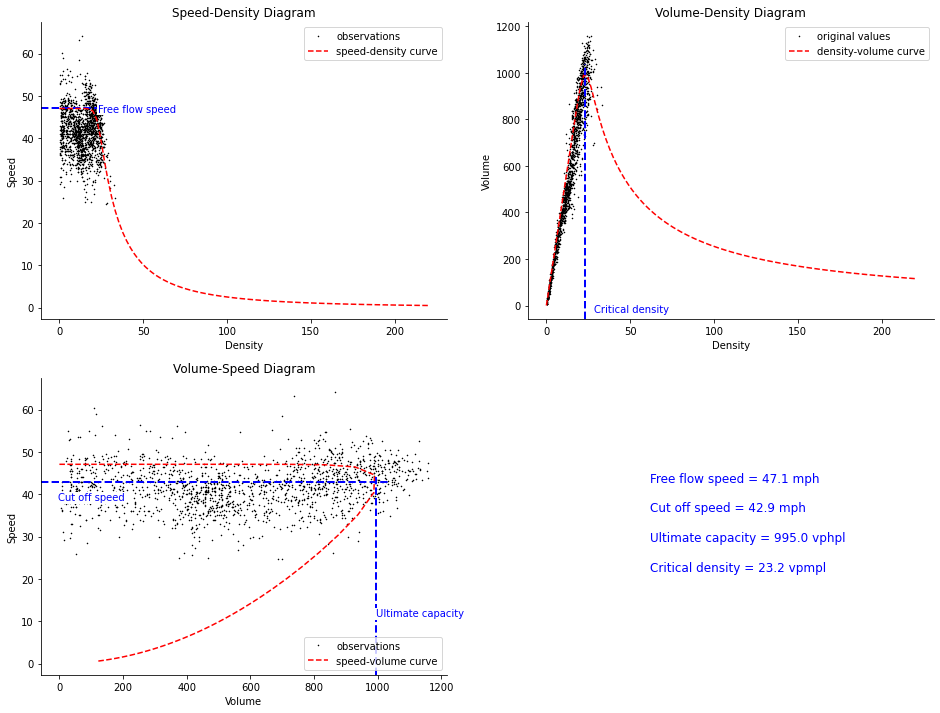

Calibrated diagrams for  Major Arterial


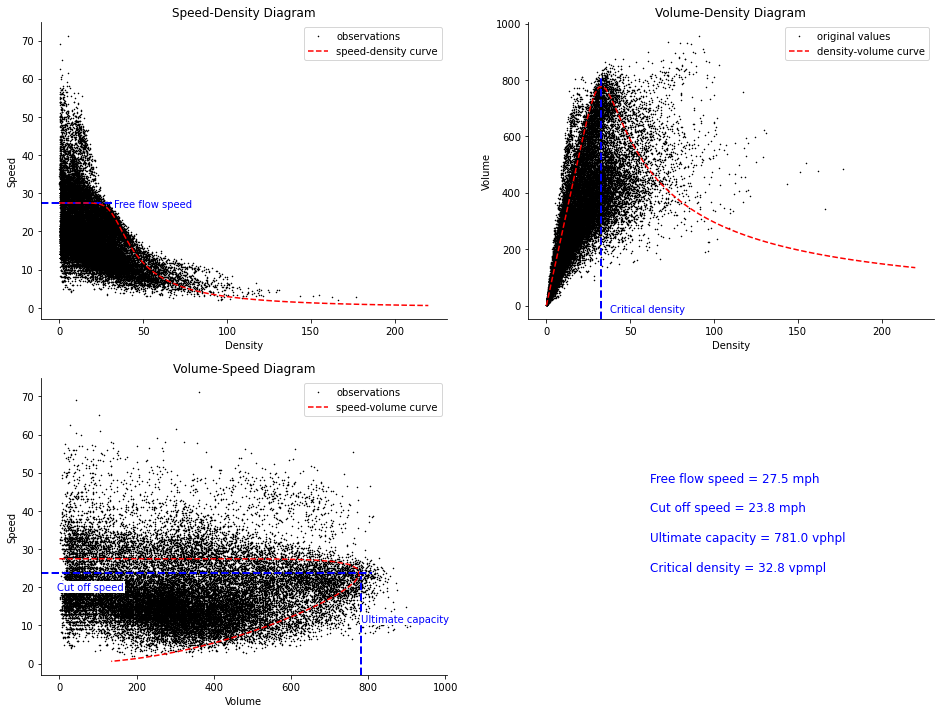

Calibrated diagrams for  Minor Arterial


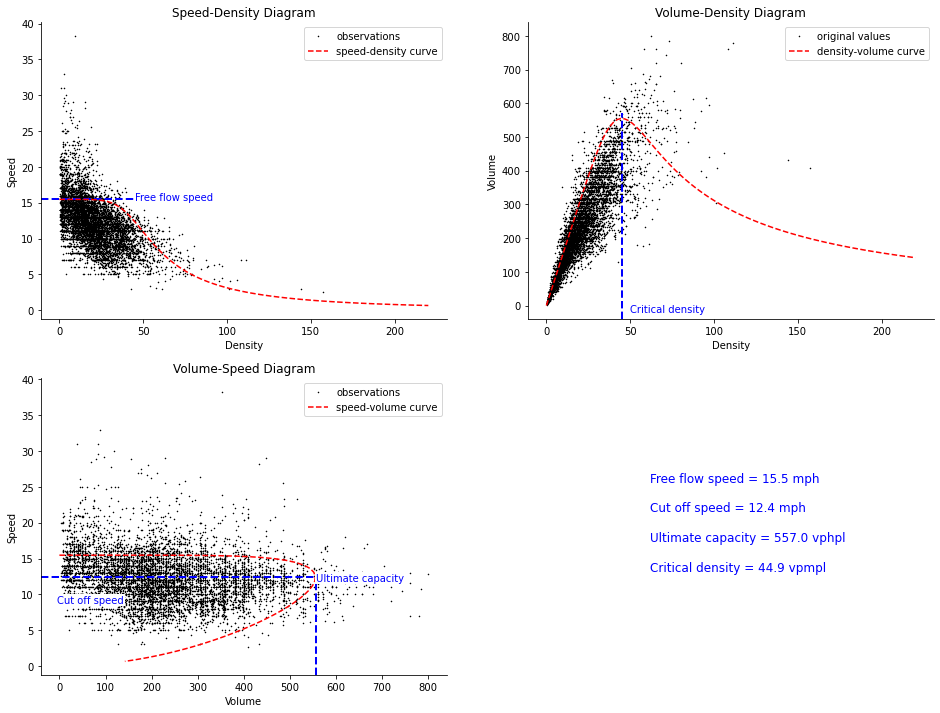

Calibrated diagrams for  Super Arterial


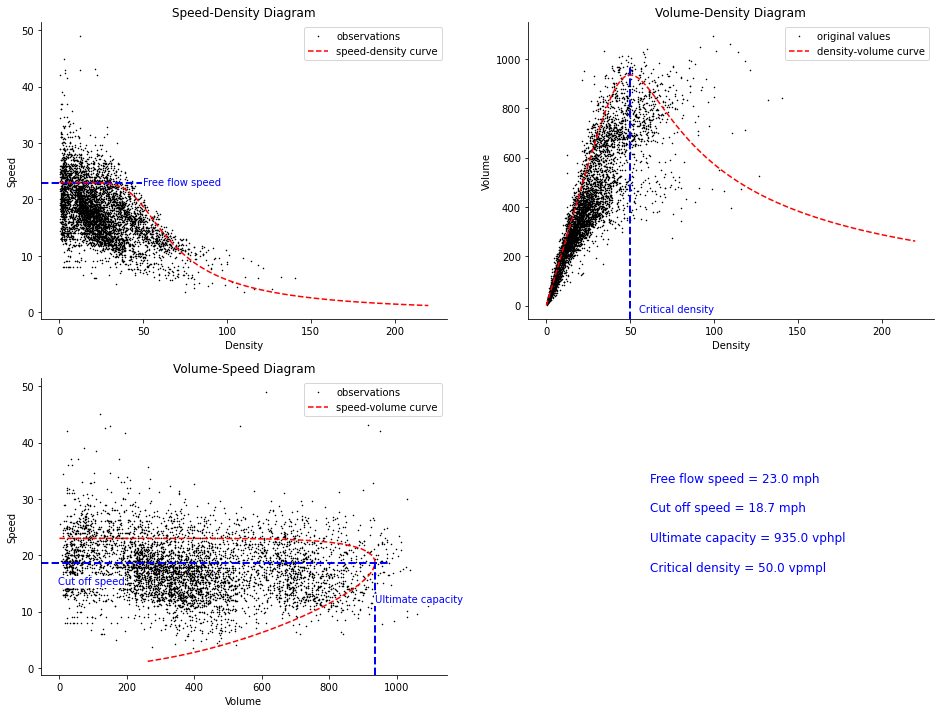

In [94]:
arterial_ft_paras = pd.DataFrame()
for ft in facility_types.keys():
    df_cal = adt_cnts_speeds_notnan[(adt_cnts_speeds_notnan['FTrev']==ft)]
    if len(df_cal)>0:
        print('Calibrated diagrams for ', facility_types[ft])
        ft_speed_at_capacity,ft_ultimate_capacity,ft_critical_density,ft_free_flow_speed,ft_mm=_calibrate_traffic_flow_model(df_cal, 'Arterials_FT' + str(ft))
        df_cal['speed_at_capacity'] = ft_speed_at_capacity
        df_cal['ultimate_capacity'] = ft_ultimate_capacity
        df_cal['critical_density'] = ft_critical_density
        df_cal['free_flow_speed'] = ft_free_flow_speed
        df_cal['mm'] = ft_mm
        arterial_ft_paras = arterial_ft_paras.append(df_cal, ignore_index=True)

In [95]:
arterial_ft_paras['vcratio'] = arterial_ft_paras['density']/arterial_ft_paras['critical_density']

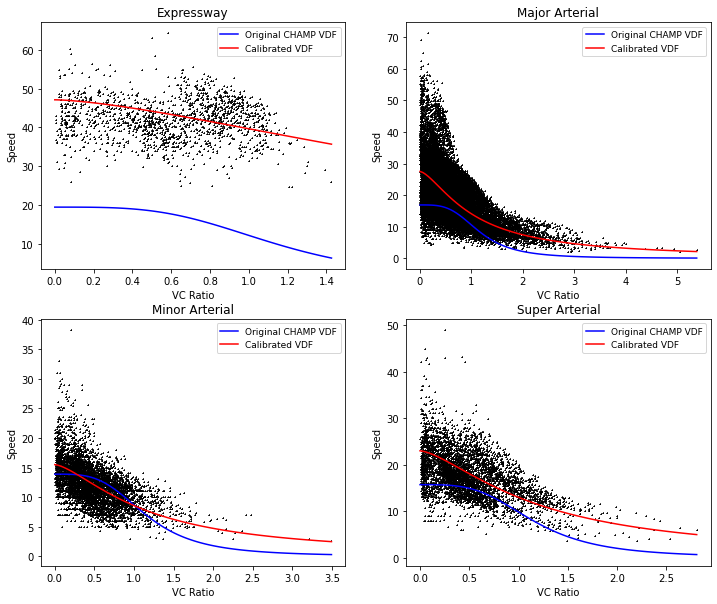

In [96]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
subid = 0
ft_vars = {}

#Original values from CHAMP
if ft == 3:
    alpha0, beta0, rho0 = 0.71, 2.1, 1
else:
    alpha0, beta0, rho0 = 0.6, 3.5, 1.8
p0 = [alpha0, beta0]  # initial parameters

#calibration bounds
lower_alpha, upper_alpha = 0.15, 10
lower_beta, upper_beta = 1.5, 10
lowerbound_fitting=[lower_alpha, lower_beta]
upperbound_fitting=[upper_alpha, upper_beta]

def _bpr_func1(x_vc, alpha, beta):  # input x_vc, alpha and beta to be calibrated
    return ffs_calib/(1+alpha*np.power(x_vc,beta))

for ft in facility_types.keys():
    df_cal = arterial_ft_paras[arterial_ft_paras['FTrev']==ft]
    if len(df_cal)>0:
        x_demand_over_capacity = np.array(df_cal['vcratio'])
        y_speed = np.array(df_cal['speed'])

        ffs_champ = df_cal.SPEED.mean()
        ffs_calib = df_cal.free_flow_speed.mean()

        popt, pcov = curve_fit(_bpr_func1, x_demand_over_capacity, y_speed, p0, bounds=[lowerbound_fitting, upperbound_fitting], method='trf')
        alpha1, beta1 = popt

        vc_list = np.linspace(0, df_cal['vcratio'].max(),100)
        tt_list_org = [ffs_champ/rho0/(1 + alpha0*np.power(vc,beta0)) for vc in vc_list]
        tt_list_cal = [ffs_calib/(1 + alpha1*np.power(vc,beta1)) for vc in vc_list]

        row, col = subid//2, subid%2
        ax[row, col].scatter(x = df_cal['vcratio'], y = df_cal['speed'], c='black', marker='+', s = 1)
        ax[row, col].plot(vc_list, tt_list_org, c='blue', label='Original CHAMP VDF')
        ax[row, col].plot(vc_list, tt_list_cal, c='red', label='Calibrated VDF')
        ax[row, col].legend(loc='upper right', prop={'size': 9})
        ax[row, col].set_xlabel('VC Ratio')
        ax[row, col].set_ylabel('Speed')
        ax[row, col].set_title(facility_types[ft])

        cal_vars = [(alpha0, beta0), (round(alpha1,3), round(beta1,3))]
        ft_vars[ft] = cal_vars

        subid += 1
#plt.savefig(os.path.join(vdf_dir, 'Arterials_FacilityType_Calibration.png'), bbox_inches='tight')

In [97]:
# 85% speed as FFS upper bound
ft_vars

{3: [(0.6, 3.5), (0.188, 1.5)],
 7: [(0.6, 3.5), (0.952, 1.5)],
 12: [(0.6, 3.5), (0.807, 1.5)],
 15: [(0.6, 3.5), (0.771, 1.5)]}

### By Area and Facility Types 

Calibrated diagrams for  Regional Core_Major Arterial


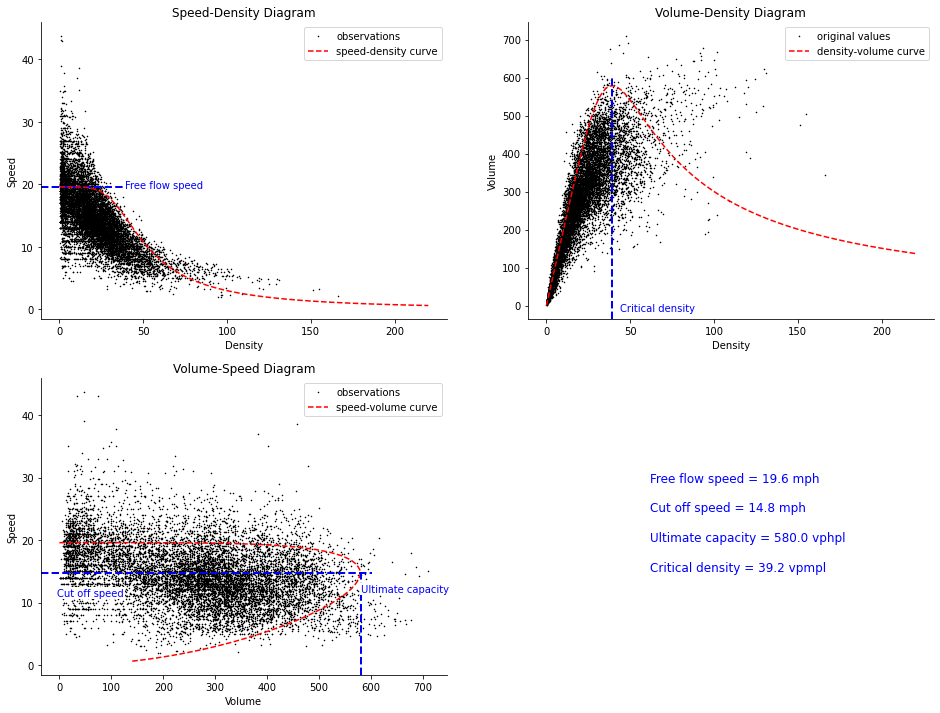

Calibrated diagrams for  Regional Core_Minor Arterial


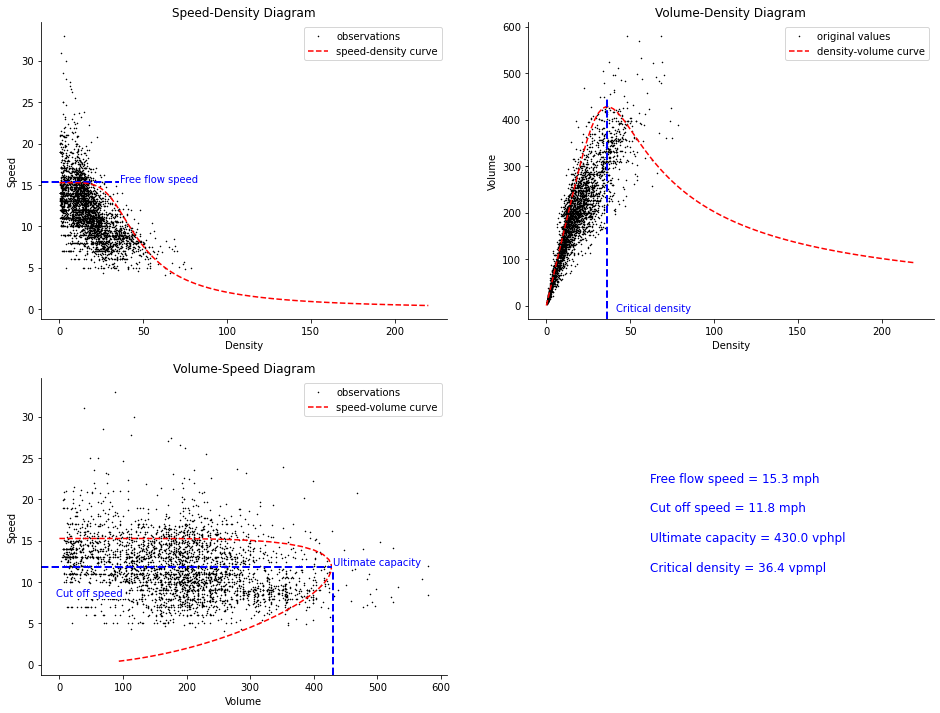

Calibrated diagrams for  Regional Core_Super Arterial


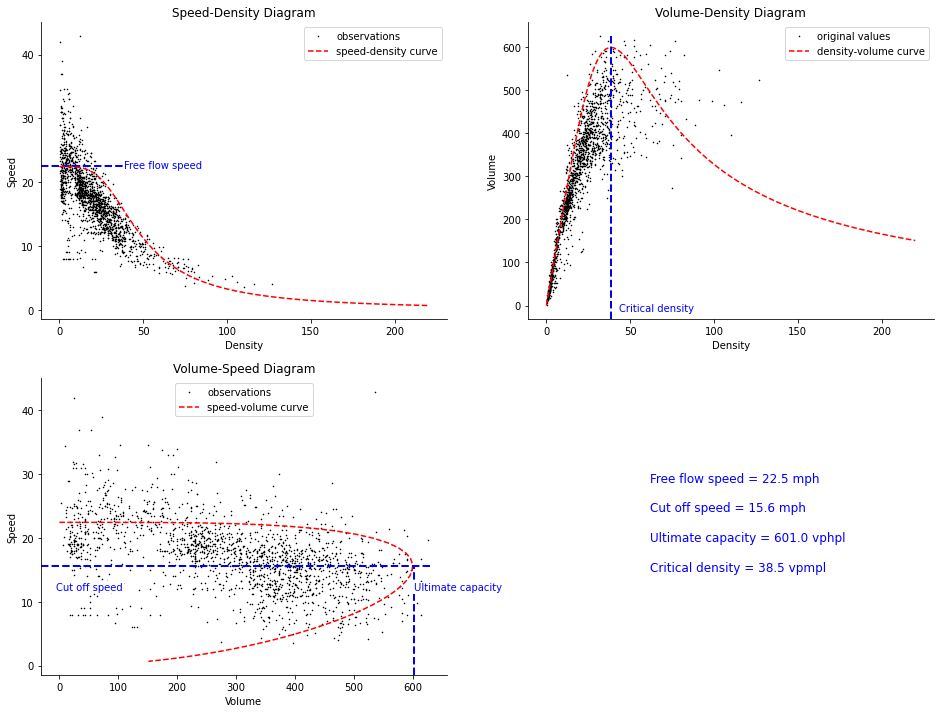

Calibrated diagrams for  CBD_Major Arterial


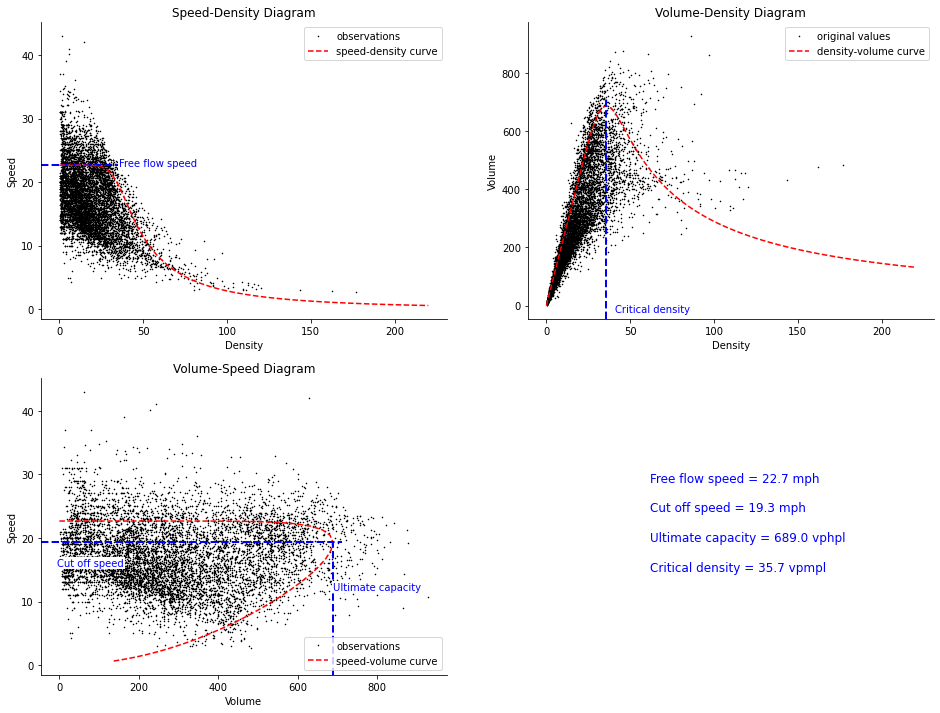

Calibrated diagrams for  CBD_Minor Arterial


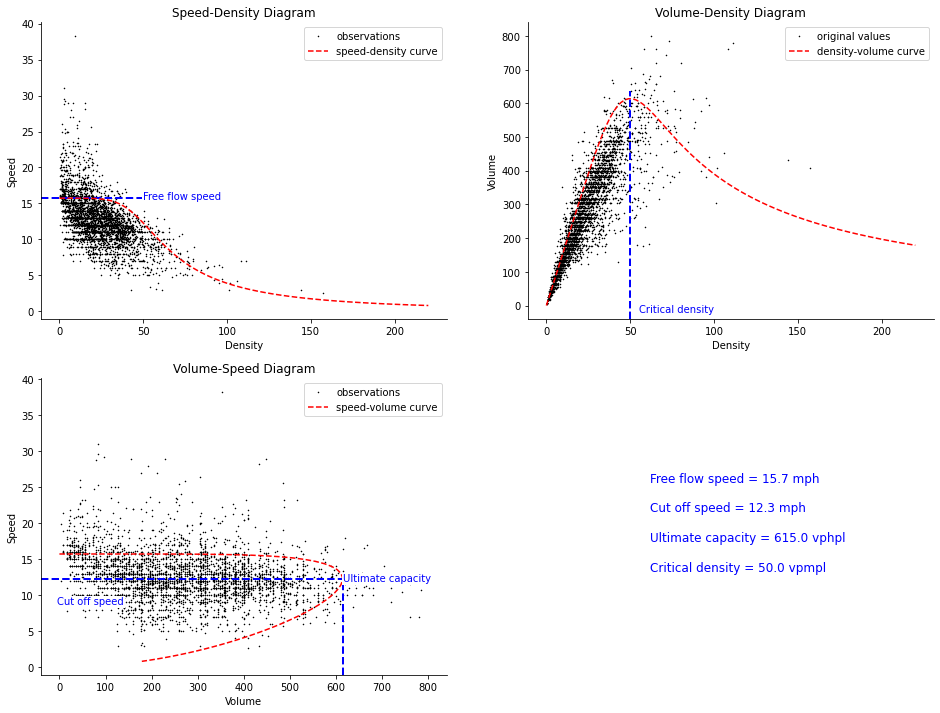

Calibrated diagrams for  CBD_Super Arterial


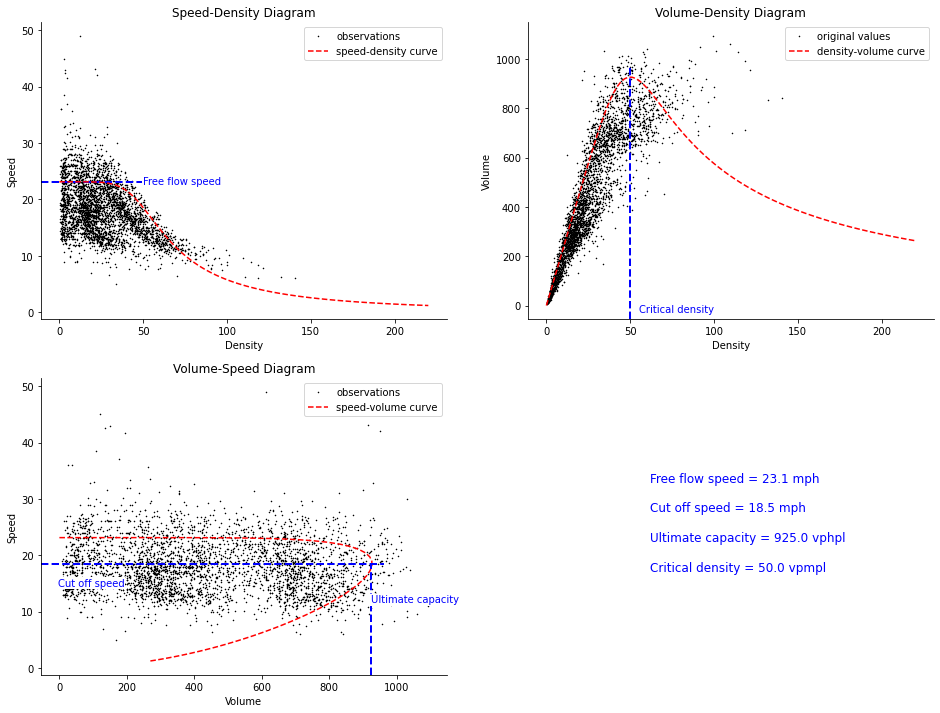

Calibrated diagrams for  Urban Business_Expressway


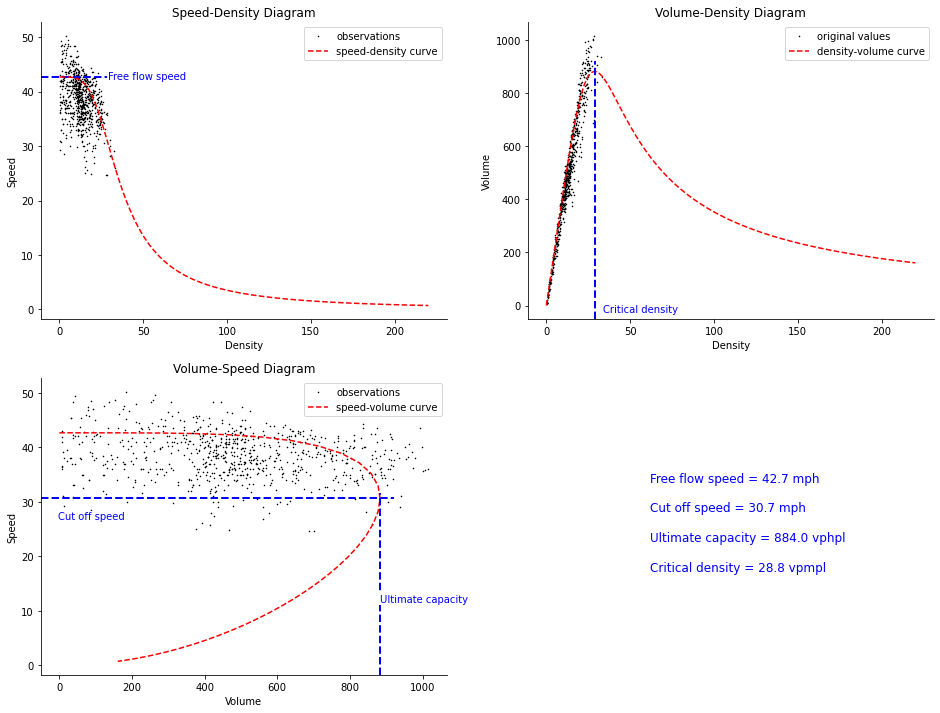

Calibrated diagrams for  Urban Business_Major Arterial


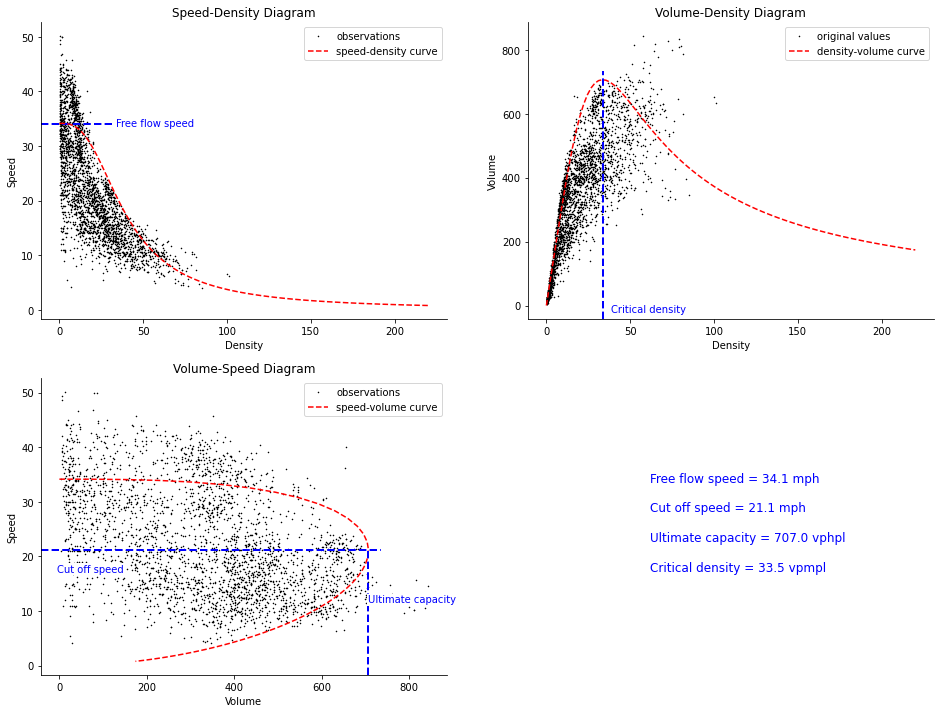

Calibrated diagrams for  Urban_Expressway


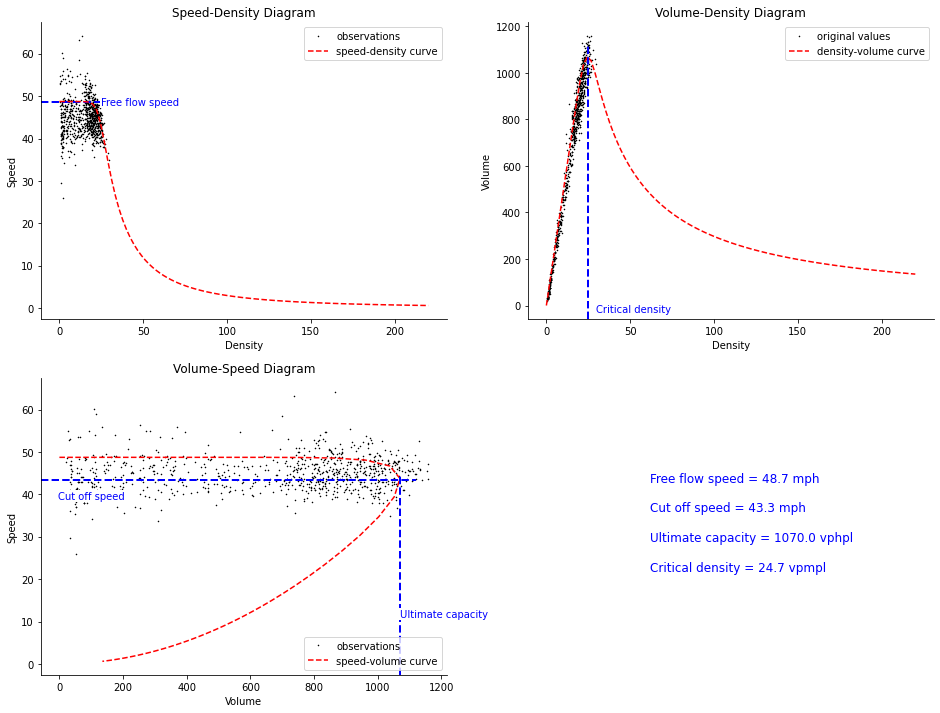

Calibrated diagrams for  Urban_Major Arterial


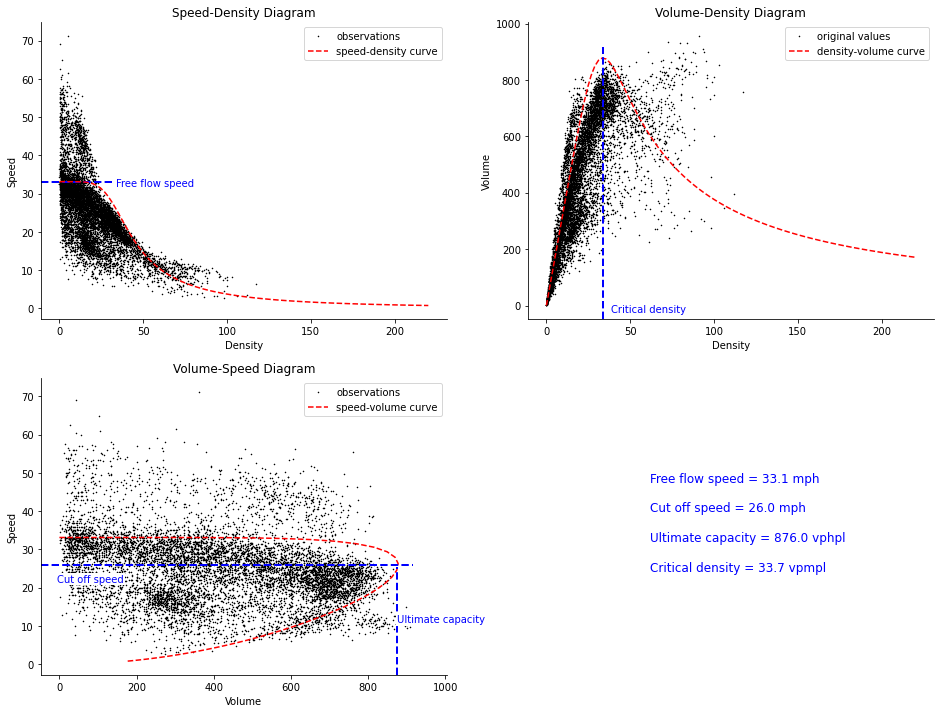

In [98]:
arterial_at_paras = pd.DataFrame()
for at in area_types.keys():
    for ft in facility_types.keys():
        df_cal = adt_cnts_speeds_notnan[(adt_cnts_speeds_notnan['AT']==at) & (adt_cnts_speeds_notnan['FTrev']==ft)]
        if len(df_cal)>0:
            print('Calibrated diagrams for ', area_types[at] + '_' + facility_types[ft])
            at_speed_at_capacity,at_ultimate_capacity,at_critical_density,at_free_flow_speed,at_mm=_calibrate_traffic_flow_model(df_cal, 'Arterials_FT' + str(ft) + '_AT' + str(at))
            df_cal['speed_at_capacity'] = at_speed_at_capacity
            df_cal['ultimate_capacity'] = at_ultimate_capacity
            df_cal['critical_density'] = at_critical_density
            df_cal['free_flow_speed'] = at_free_flow_speed
            df_cal['mm'] = at_mm
            arterial_at_paras = arterial_at_paras.append(df_cal, ignore_index=True)

In [99]:
arterial_at_paras['vcratio'] = arterial_at_paras['density']/arterial_at_paras['critical_density']

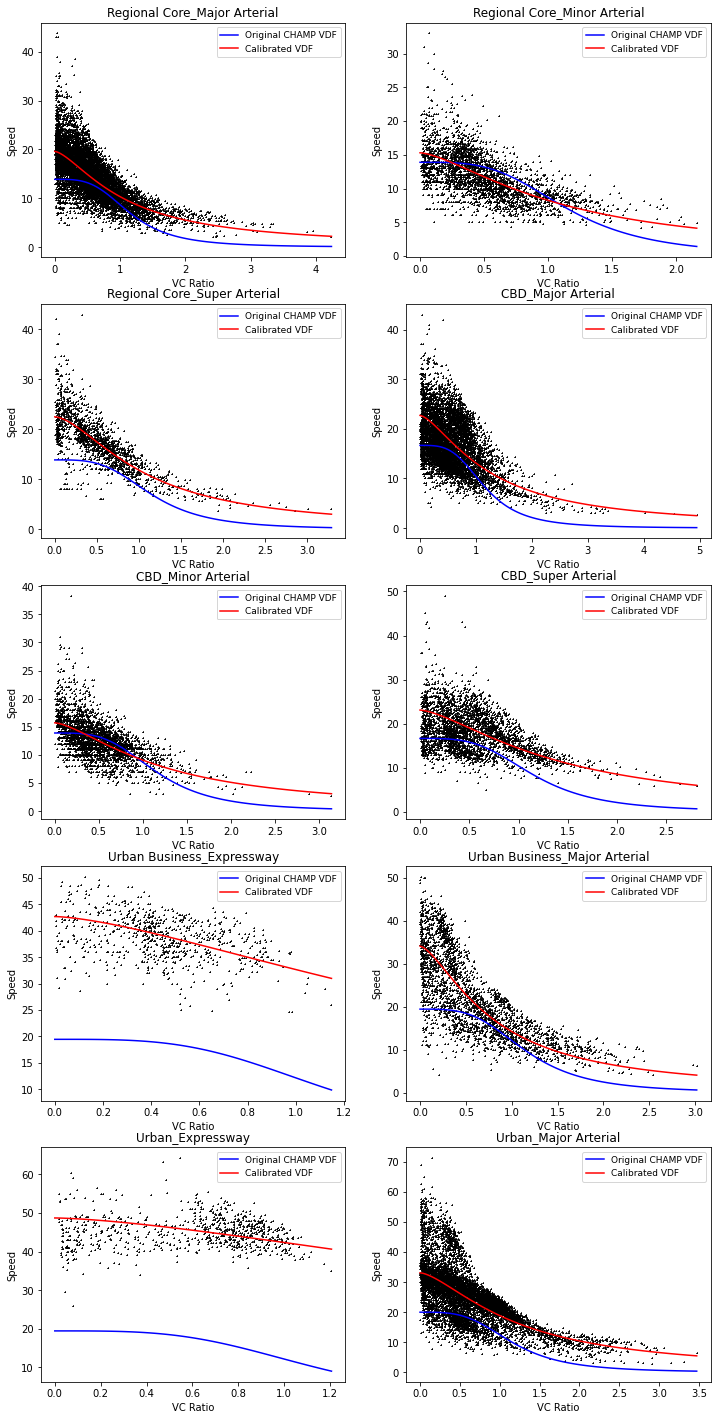

In [100]:
fig, ax = plt.subplots(5, 2, figsize=(12,25))
subid = 0
atft_vars = {}
for at in area_types.keys():
    for ft in facility_types.keys():
        df_cal = arterial_at_paras[(arterial_at_paras['AT']==at) & (arterial_at_paras['FTrev']==ft)]
        if len(df_cal)>0:
            x_demand_over_capacity = np.array(df_cal['vcratio'])
            y_speed = np.array(df_cal['speed'])
            
            ffs_champ = df_cal.SPEED.mean()
            ffs_calib = df_cal.free_flow_speed.mean()

            popt, pcov = curve_fit(_bpr_func1, x_demand_over_capacity, y_speed, p0, bounds=[lowerbound_fitting, upperbound_fitting], method='trf')
            alpha1, beta1 = popt

            vc_list = np.linspace(0, df_cal['vcratio'].max(),100)
            tt_list_org = [ffs_champ/rho0/(1 + alpha0*np.power(vc,beta0)) for vc in vc_list]
            tt_list_cal = [ffs_calib/(1 + alpha1*np.power(vc,beta1)) for vc in vc_list]
            
            row, col = subid//2, subid%2
            ax[row, col].scatter(x = df_cal['vcratio'], y = df_cal['speed'], c='black', marker='+', s = 1)
            ax[row, col].plot(vc_list, tt_list_org, c='blue', label='Original CHAMP VDF')
            ax[row, col].plot(vc_list, tt_list_cal, c='red', label='Calibrated VDF')
            ax[row, col].legend(loc='upper right', prop={'size': 9})
            ax[row, col].set_xlabel('VC Ratio')
            ax[row, col].set_ylabel('Speed')
            ax[row, col].set_title(area_types[at] + '_' + facility_types[ft])

            out_vars = [(alpha0, beta0), (round(alpha1,3), round(beta1,3))]
            atft_vars[(at, ft)] = out_vars
            
            subid += 1
#plt.savefig(os.path.join(vdf_dir, 'Arterials_AreaType_FacilityType_Calibration.png'), bbox_inches='tight')

In [101]:
atft_vars

{(0, 7): [(0.6, 3.5), (0.896, 1.5)],
 (0, 12): [(0.6, 3.5), (0.856, 1.5)],
 (0, 15): [(0.6, 3.5), (0.898, 1.651)],
 (1, 7): [(0.6, 3.5), (0.731, 1.5)],
 (1, 12): [(0.6, 3.5), (0.733, 1.5)],
 (1, 15): [(0.6, 3.5), (0.6, 1.5)],
 (2, 3): [(0.6, 3.5), (0.307, 1.5)],
 (2, 7): [(0.6, 3.5), (1.395, 1.5)],
 (3, 3): [(0.6, 3.5), (0.15, 1.5)],
 (3, 7): [(0.6, 3.5), (0.752, 1.524)]}

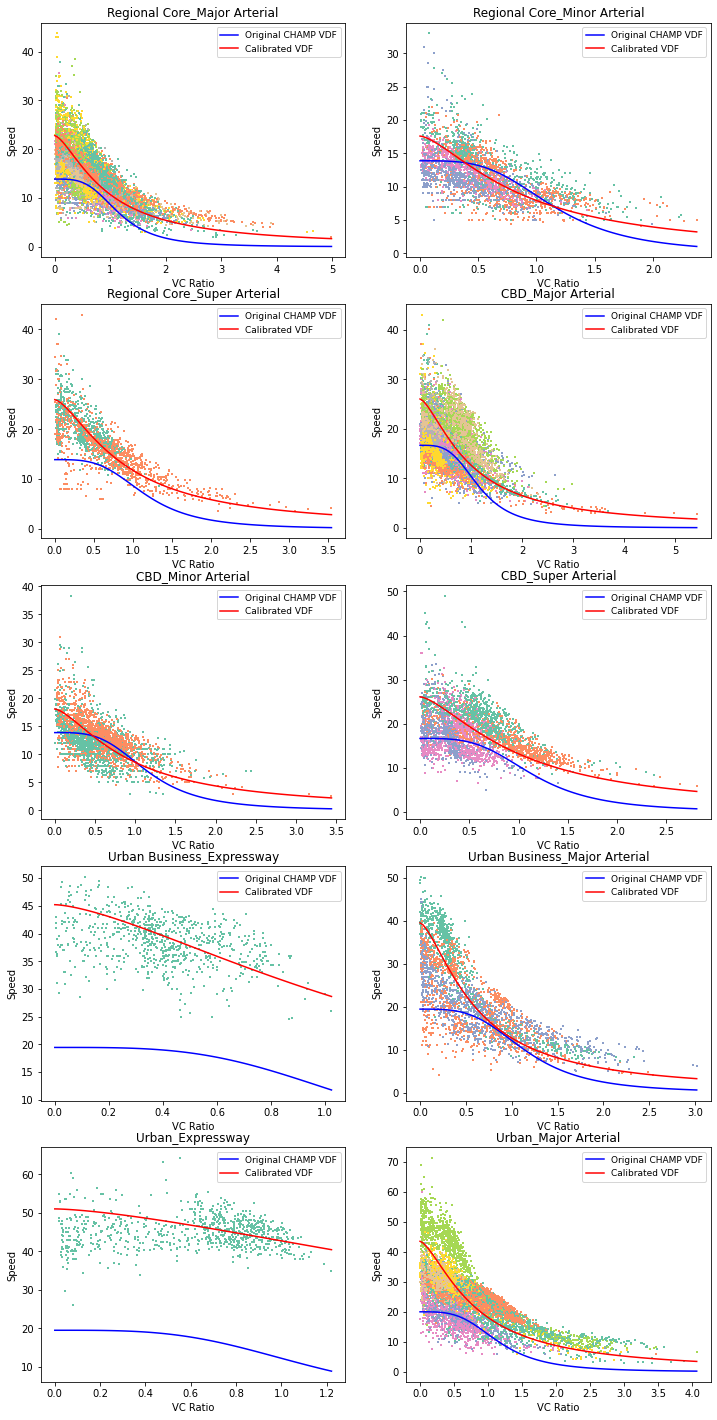

In [42]:
fig, ax = plt.subplots(5, 2, figsize=(12,25))
subid = 0
atft_vars = {}
for at in area_types.keys():
    for ft in facility_types.keys():
        df_cal = arterial_at_paras[(arterial_at_paras['AT']==at) & (arterial_at_paras['FTrev']==ft)]
        if len(df_cal)>0:
            x_demand_over_capacity = np.array(df_cal['vcratio'])
            y_speed = np.array(df_cal['speed'])
            
            ffs_champ = df_cal.SPEED.mean()
            ffs_calib = df_cal.free_flow_speed.mean()

            popt, pcov = curve_fit(_bpr_func1, x_demand_over_capacity, y_speed, p0, bounds=[lowerbound_fitting, upperbound_fitting], method='trf')
            alpha1, beta1 = popt

            vc_list = np.linspace(0, df_cal['vcratio'].max(),100)
            tt_list_org = [ffs_champ/rho0/(1 + alpha0*np.power(vc,beta0)) for vc in vc_list]
            tt_list_cal = [ffs_calib/(1 + alpha1*np.power(vc,beta1)) for vc in vc_list]
            
            row, col = subid//2, subid%2
            color_labels = df_cal['ID_Dir'].unique()
            rgb_values = sns.color_palette("Set2", len(color_labels))
            color_map = dict(zip(color_labels, rgb_values))
            ax[row, col].scatter(x = df_cal['vcratio'], y = df_cal['speed'],
                                 c=df_cal['ID_Dir'].map(color_map), marker='+', s = 4)
            ax[row, col].plot(vc_list, tt_list_org, c='blue', label='Original CHAMP VDF')
            ax[row, col].plot(vc_list, tt_list_cal, c='red', label='Calibrated VDF')
            ax[row, col].legend(loc='upper right', prop={'size': 9})
            ax[row, col].set_xlabel('VC Ratio')
            ax[row, col].set_ylabel('Speed')
            ax[row, col].set_title(area_types[at] + '_' + facility_types[ft])
            
            subid += 1

# Freeway PeMS

## Processing Data

### PeMS Data 

In [46]:
def get_dir(base, year=2021, data_type='station_hour', district=4):
    if data_type in ['station_hour','station_5min','station_meta']:
        return os.path.join(pems_dir,'D{}_Data_{}\{}'.format(district,year,data_type))
def get_columns(data_type, num_cols):
    if data_type == 'station_meta':
        columns = ['station','route','dir','district','county','city','state_postmile','abs_postmile','latitude','longitude',
                   'length','type','lanes','name','user_id_1','user_id_2','user_id_3','user_id_4']
    if data_type == 'station_hour':
        columns = ['timestamp', 'station', 'district', 'route', 'dir', 'lane_type', 'station_length',
                   'samples', 'obs_pct', 'total_flow', 'avg_occupancy', 'avg_speed',
                   'delay_35','delay_40','delay_45','delay_50','delay_55','delay_60']
        for i in range(0, int((num_cols - 18) / 3)):
            columns += [f'lane_{i}_flow',
                        f'lane_{i}_avg_occ',
                        f'lane_{i}_avg_speed',
                       ]
    if data_type == 'station_5min':
        columns = ['timestamp', 'station', 'district', 'route', 'dir', 'lane_type', 'station_length',
                   'samples', 'obs_pct', 'total_flow', 'avg_occupancy', 'avg_speed']
        for i in range(0, int((num_cols - 12) / 5)):
            columns += [f'lane_{i}_samples',
                        f'lane_{i}_flow',
                        f'lane_{i}_avg_occ',
                        f'lane_{i}_avg_speed',
                        f'lane_{i}_avg_obs',
                       ]
    return columns

In [47]:
unzip = False
source = 'gz' # or 'zip','text','txt'
save_h5 = True
data_type = 'station_5min'
district = 4
ca_holidays = holidays.UnitedStates(state='CA')
sep = ','

for year in np.arange(2021,2022):
    year_dfs = []
    path = get_dir(pems_dir, year, data_type, district)
    outpath = os.path.join(pems_dir,'pems')
    contents = os.listdir(path)
    gzs = filter(lambda x: os.path.splitext(x)[1] == '.gz', contents)
    txts = filter(lambda x: os.path.splitext(x)[1] == '.txt', contents)

    if source == 'gz':
        files = gzs
        compression = 'gzip'
    else:
        files = txts
        compression = None

    header = 0 if data_type == 'station_meta' else None

    for f in files:
        print(f)
        try:
            df = pd.read_csv(os.path.join(path, f), 
                             sep=sep,
                             header=header, 
                             index_col=False, 
                             parse_dates=[0], 
                             infer_datetime_format=True,
                             compression=compression)
        except Exception as e:
            print(e)
            print('trying no quotechar...')
            try:
                df = pd.read_csv(os.path.join(path, f), 
                                 sep=sep,
                                 header=header, 
                                 index_col=False, 
                                 parse_dates=[0], 
                                 infer_datetime_format=True,
                                 quotechar=None,
                                 compression=compression)

            except Exception as e2:
                print(e2)
                continue

        try:
            df.columns = get_columns(data_type, len(df.columns))
        except Exception as e3:
            print(e3)
            continue
        if data_type == 'station_meta':
            y, m, d = f.replace('d{:02d}_text_meta_'.format(district),'').replace('.txt','').split('_')
            ts = dt.datetime(int(y), int(m), int(d))
            date = ts.date()
            df['timestamp'] = ts
            df['date'] = date
            df['year'] = y
            df['month'] = m
            df['day'] = d
            meta.append(df)
        elif data_type == 'station_hour':
            df['date'] = df['timestamp'].map(lambda x: x.date())
            df['year'] = df['timestamp'].map(lambda x: x.year)
            df['month'] = df['timestamp'].map(lambda x: x.month)
            df['day'] = df['timestamp'].map(lambda x: x.day)
            df['hour'] = df['timestamp'].map(lambda x: x.hour)
            df['day_of_week'] = df['timestamp'].map(lambda x: x.weekday())
            df['is_holiday'] = df['timestamp'].map(lambda x: x.date() in ca_holidays)
            year_dfs.append(df)
        elif data_type == 'station_5min':
            df['date'] = df['timestamp'].map(lambda x: x.date())
            df['year'] = df['timestamp'].map(lambda x: x.year)
            df['month'] = df['timestamp'].map(lambda x: x.month)
            df['day'] = df['timestamp'].map(lambda x: x.day)
            df['hour'] = df['timestamp'].map(lambda x: x.hour)
            df['minute'] = df['timestamp'].map(lambda x: x.minute)
            df['day_of_week'] = df['timestamp'].map(lambda x: x.weekday())
            df['is_holiday'] = df['timestamp'].map(lambda x: x.date() in ca_holidays)
            year_dfs.append(df)
            
    y = pd.concat(year_dfs)
#     try:
#         y.to_hdf(os.path.join(OUTDIR,'pems_station_hour_{}.h5'.format(year)), 'data')
#     except Exception as e:
#         print(e)

d04_text_station_5min_2021_04_01.txt.gz
d04_text_station_5min_2021_04_02.txt.gz
d04_text_station_5min_2021_04_03.txt.gz
d04_text_station_5min_2021_04_04.txt.gz
d04_text_station_5min_2021_04_05.txt.gz
d04_text_station_5min_2021_04_06.txt.gz
d04_text_station_5min_2021_04_07.txt.gz
d04_text_station_5min_2021_04_08.txt.gz
d04_text_station_5min_2021_04_09.txt.gz
d04_text_station_5min_2021_04_10.txt.gz
d04_text_station_5min_2021_04_11.txt.gz
d04_text_station_5min_2021_04_12.txt.gz
d04_text_station_5min_2021_04_13.txt.gz
d04_text_station_5min_2021_04_14.txt.gz
d04_text_station_5min_2021_04_15.txt.gz
d04_text_station_5min_2021_04_16.txt.gz
d04_text_station_5min_2021_04_17.txt.gz
d04_text_station_5min_2021_04_18.txt.gz
d04_text_station_5min_2021_04_19.txt.gz
d04_text_station_5min_2021_04_20.txt.gz
d04_text_station_5min_2021_04_21.txt.gz
d04_text_station_5min_2021_04_22.txt.gz
d04_text_station_5min_2021_04_23.txt.gz
d04_text_station_5min_2021_04_24.txt.gz
d04_text_station_5min_2021_04_25.txt.gz


In [48]:
stations = pd.read_csv(os.path.join(pems_dir,pems_stations), delimiter = "\t")
#PeMS stations in SF
sf_stations = stations[stations['County']==75]

#PeMS counts in SF
sf_counts_21 = y[y['station'].isin(sf_stations['ID'])]

In [50]:
sf_counts_21['epoch'] = sf_counts_21['hour'] * 4 + sf_counts_21['minute']//15  # convert to 15-min epoch

#Aggregate from 5-min to 15-min epoch counts
grpby_cols = ['station', 'lane_type', 'date', 'hour', 'epoch']
sf_counts_agg_21 = sf_counts_21.groupby(grpby_cols).agg({'total_flow':'sum',
                                                   'avg_speed': 'mean',
                                                      'timestamp': 'count'
                                                     }).reset_index()
sf_counts_agg_21.columns = grpby_cols + ['total_flow', 'speed', 'numofintervals']

In [51]:
sf_counts_agg_21 = sf_counts_agg_21[sf_counts_agg_21['numofintervals']==3] # select data with all three 5-min intervals
sf_counts_agg_21 = sf_counts_agg_21.merge(sf_stations[['ID', 'Lanes']], left_on='station', right_on='ID', how='left')

In [52]:
sf_counts_agg_21['hourly_volume_per_lane'] = sf_counts_agg_21['total_flow'] * 4 / sf_counts_agg_21['Lanes']
sf_counts_agg_21['density'] = sf_counts_agg_21['hourly_volume_per_lane'] / sf_counts_agg_21['speed']

In [53]:
station_champ = pd.read_csv(os.path.join(pems_dir, pems_stations_champ))
station_champ=station_champ[station_champ['remove']=='no']

sf_flow_speed = sf_counts_agg_21[sf_counts_agg_21['station'].isin(station_champ['ID'])]

In [54]:
sf_flow_speed = sf_flow_speed.merge(station_champ[['ID', 'Fwy', 'Dir', 'champ_link', 'inrix_segid']], on='ID', how='left')
sf_flow_speed = sf_flow_speed.merge(champ[['AB', 'CAP', 'AT', 'FT', 'SPEED', 'DISTANCE', 'TIME']], 
                                    left_on= 'champ_link', right_on = 'AB', how='left')

In [55]:
sf_flow_speed.lane_type.unique()

array(['ML', 'FR', 'OR'], dtype=object)

In [63]:
sf_flow_speed_ml = sf_flow_speed[sf_flow_speed['lane_type']=='ML']
print('number of data points on mainlines: ', len(sf_flow_speed_ml))
sf_flow_speed_ramp = sf_flow_speed[sf_flow_speed['lane_type']!='ML']
print('number of data points on ramps: ', len(sf_flow_speed_ramp))

number of data points on mainlines:  211638
number of data points on ramps:  56144


In [64]:
ml_ptiles = sf_flow_speed_ml.groupby('AT').agg({'speed': [percentile(25), percentile(50), 'mean', percentile(75), 
                                                          percentile(85), percentile(95), percentile(99)]}).reset_index()
ml_ptiles.columns = ['AT', 'pcnt25', 'pcnt50', 'mean', 'pcnt75', 'pcnt85', 'pcnt95', 'pcnt99']
ml_ptiles

AT     pcnt25     pcnt50       mean     pcnt75     pcnt85     pcnt95  \
0   1  58.400000  65.566667  60.519995  67.766667  69.033333  70.100000   
1   2  64.100000  66.200000  64.299108  68.166667  68.866667  69.933333   
2   3  63.466667  66.633333  65.000859  69.700000  71.033333  72.266667   

      pcnt99  
0  71.833333  
1  71.800000  
2  73.400000

### Ramp INRIX Speed Data 

In [65]:
for p in ramp_speed_files:
    ramp_speed = pd.read_csv(os.path.join(speed_dir, '%s%s\data.csv' %(p[0],p[1])))

In [66]:
ramp_speed.rename(columns={'Segment ID':'XDSegID', 'Speed(miles/hour)':'speed'}, inplace=True)
ramp_speed['Date_Time'] = ramp_speed['Date Time'].str[:19]
ramp_speed['Date_Time'] = ramp_speed['Date_Time'].str.replace('T', " ")
ramp_speed['Date'] = ramp_speed['Date_Time'].str[:10]
ramp_speed['rDate']=pd.to_datetime(ramp_speed['Date'])
ramp_speed['hour']= ramp_speed['Date_Time'].str[11:13].astype(int)
ramp_speed['minute']= ramp_speed['Date_Time'].str[14:16].astype(int)
ramp_speed['epoch']= ramp_speed['hour'] * 4 + ramp_speed['minute']//15  # convert each minute to 15-min epoch

In [71]:
grpby_cols = ['XDSegID', 'rDate', 'hour', 'epoch']
ramp_speed_15min = ramp_speed.groupby(grpby_cols).agg({'speed':['mean', 'count']}).reset_index()
ramp_speed_15min.columns = ['inrix_segid', 'date', 'hour', 'epoch', 'speed', 'numof1minutes']
ramp_speed_15min['date'] = ramp_speed_15min['date'].map(lambda x: x.date())

In [72]:
sf_flow_speed_ramp['inrix_segid'] = sf_flow_speed_ramp['inrix_segid'].astype(int)
del sf_flow_speed_ramp['speed'] 
sf_flow_speed_ramp_inrix = sf_flow_speed_ramp.merge(ramp_speed_15min, on=['inrix_segid', 'date', 'hour', 'epoch'], how='left')
sf_flow_speed_ramp_inrix = sf_flow_speed_ramp_inrix[pd.notnull(sf_flow_speed_ramp_inrix['speed'])]
sf_flow_speed_ramp_inrix = sf_flow_speed_ramp_inrix[sf_flow_speed_ramp_inrix['hourly_volume_per_lane']>0]

In [76]:
sf_flow_speed_ramp_inrix['density'] = sf_flow_speed_ramp_inrix['hourly_volume_per_lane'] / sf_flow_speed_ramp_inrix['speed']

In [73]:
ramp_ptiles = sf_flow_speed_ramp_inrix.groupby('AT').agg({'speed': [percentile(25), percentile(50), 'mean', percentile(75), 
                                                          percentile(85), percentile(95), percentile(99)]}).reset_index()
ramp_ptiles.columns = ['AT', 'pcnt25', 'pcnt50', 'mean', 'pcnt75', 'pcnt85', 'pcnt95', 'pcnt99']
ramp_ptiles

AT     pcnt25     pcnt50       mean     pcnt75     pcnt85     pcnt95  \
0   2  35.533333  42.866667  42.444703  51.200000  54.200000  57.800000   
1   3  27.000000  30.666667  31.072721  34.733333  37.266667  42.333333   

   pcnt99  
0  61.400  
1  47.606

## Scatter Plots 

### Mainline

In [56]:
sf_flow_speed_ml = sf_flow_speed[sf_flow_speed['lane_type']=='ML']

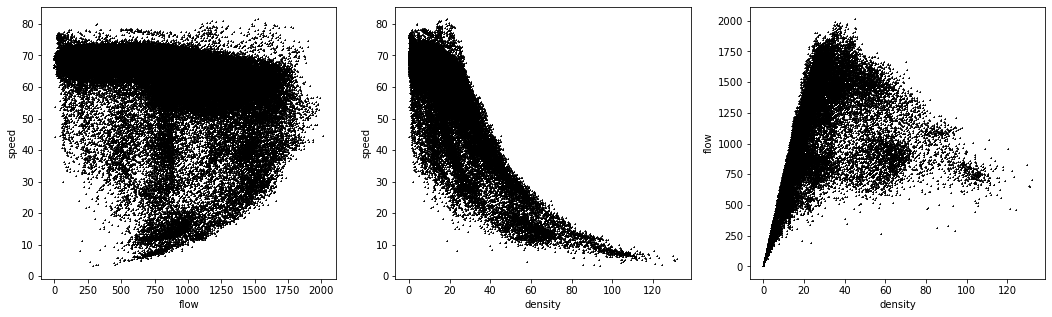

In [57]:
flow_scatter(sf_flow_speed_ml, col_flow ='hourly_volume_per_lane', col_speed= 'speed', col_density = 'density')

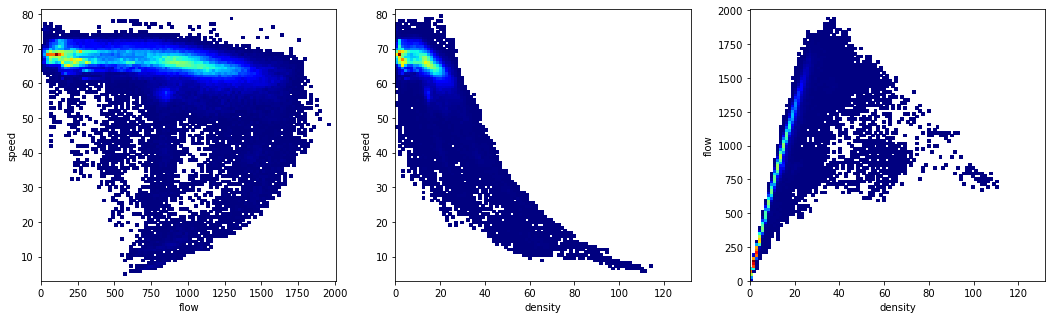

In [62]:
df, col_flow, col_speed, col_density = sf_flow_speed_ml, 'hourly_volume_per_lane', 'speed', 'density'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.hist2d(df[col_flow], df[col_speed], (100, 100), cmin=3, cmap=plt.cm.jet)
ax1.set_xlabel('flow')
ax1.set_ylabel('speed')

ax2.hist2d(df[col_density], df[col_speed], (100, 100), cmin=3, cmap=plt.cm.jet)
ax2.set_xlabel('density')
ax2.set_ylabel('speed')

ax3.hist2d(df[col_density], df[col_flow], (100, 100), cmin=3, cmap=plt.cm.jet)
ax3.set_xlabel('density')
ax3.set_ylabel('flow')
plt.show()

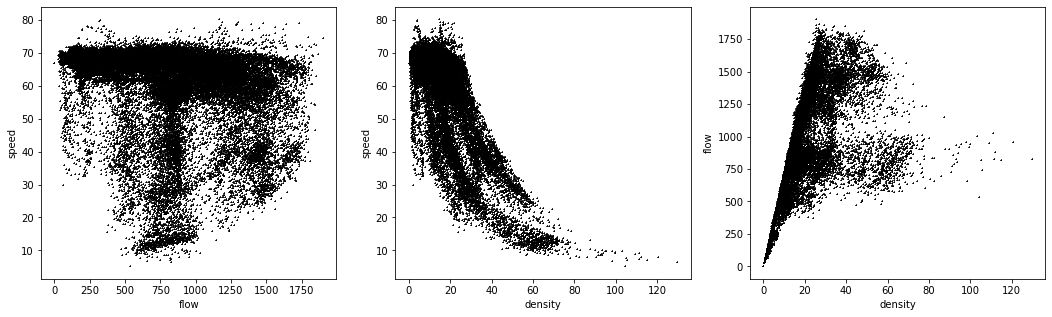

In [59]:
flow_scatter(sf_flow_speed_ml[sf_flow_speed_ml['AT']==1], col_flow ='hourly_volume_per_lane', col_speed= 'speed', col_density = 'density')

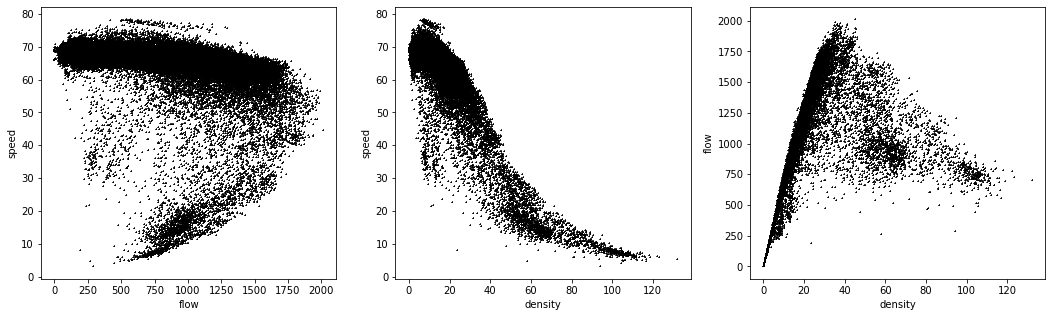

In [60]:
flow_scatter(sf_flow_speed_ml[sf_flow_speed_ml['AT']==2], col_flow ='hourly_volume_per_lane', col_speed= 'speed', col_density = 'density')

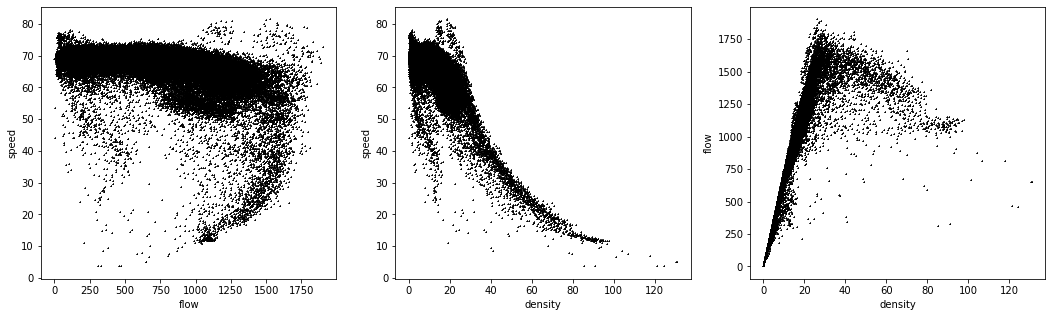

In [61]:
flow_scatter(sf_flow_speed_ml[sf_flow_speed_ml['AT']==3], col_flow ='hourly_volume_per_lane', col_speed= 'speed', col_density = 'density')

### Ramp

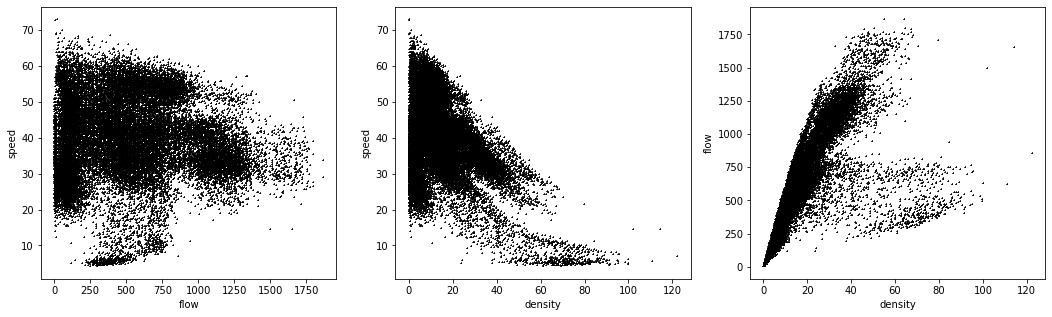

In [77]:
flow_scatter(sf_flow_speed_ramp_inrix, col_flow ='hourly_volume_per_lane', col_speed= 'speed', col_density = 'density')

## Calibration 

### Mainline 

#### Overall 

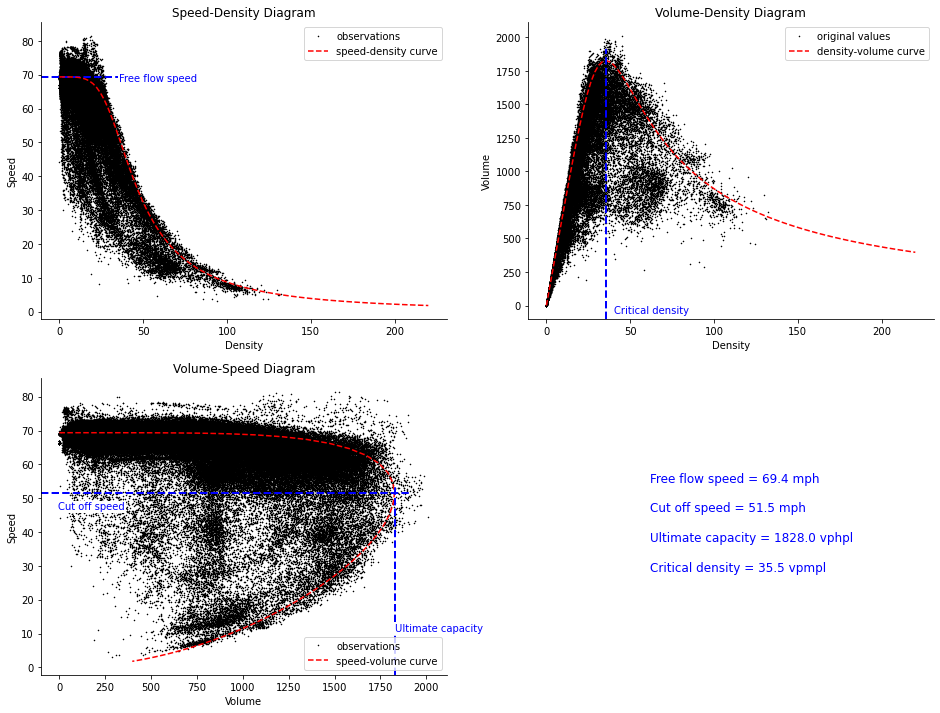

51.5 1828.0 35.5 69.4 4.64


In [102]:
ml_speed_at_capacity,ml_ultimate_capacity,ml_critical_density,ml_free_flow_speed,ml_mm=_calibrate_traffic_flow_model(sf_flow_speed_ml, 'Freeway_Mainline')
print(ml_speed_at_capacity,ml_ultimate_capacity,ml_critical_density,ml_free_flow_speed,ml_mm)

0.83 5.5
0.644 2.7


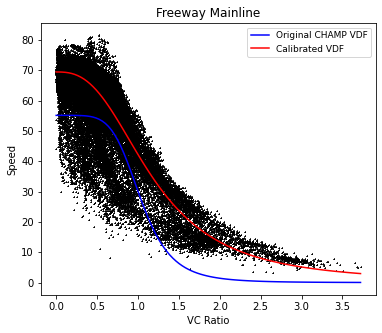

In [103]:
# Use FFS calibrated from above diagrams
fig, ax = plt.subplots(1, 1, figsize=(6,5))
subid = 0
df_cal= sf_flow_speed_ml.copy()
df_cal['vcratio'] = df_cal['density']/ml_critical_density
x_demand_over_capacity = np.array(df_cal['vcratio'])
y_speed = np.array(df_cal['speed'])

ffs_champ = df_cal.SPEED.mean()
ffs_calib = ml_free_flow_speed

#calibration bounds
lower_alpha, upper_alpha = 0.15, 5
lower_beta, upper_beta = 1.5, 10

alpha0, beta0, rho0 = 0.83, 5.5, 1

# two parameter
lowerbound_fitting=[lower_alpha, lower_beta]
upperbound_fitting=[upper_alpha, upper_beta]
p0 = [alpha0, beta0]  # initial two parameters
def _bpr_func1(x, alpha, beta):
    return ffs_calib/(1+alpha*np.power(x,beta))

popt, pcov = curve_fit(_bpr_func1, x_demand_over_capacity, y_speed, p0, bounds=[lowerbound_fitting, upperbound_fitting], method='trf')
alpha1, beta1 = popt

print(alpha0, beta0)
print(round(alpha1,3), round(beta1,3))

vc_list = np.linspace(0, df_cal['vcratio'].max(),100)
tt_list_org = [ffs_champ/rho0/(1 + alpha0*np.power(vc,beta0)) for vc in vc_list]
tt_list_cal = [ffs_calib/(1 + alpha1*np.power(vc,beta1)) for vc in vc_list]

ax.scatter(x = df_cal['vcratio'], y = df_cal['speed'], c='black', marker='+', s = 1)
ax.plot(vc_list, tt_list_org, c='blue', label='Original CHAMP VDF')
ax.plot(vc_list, tt_list_cal, c='red', label='Calibrated VDF')
ax.legend(loc='upper right', prop={'size': 9})
ax.set_xlabel('VC Ratio')
ax.set_ylabel('Speed')
ax.set_title('Freeway Mainline')
plt.show()

#### By Area Type 

Calibrated diagrams for  CBD


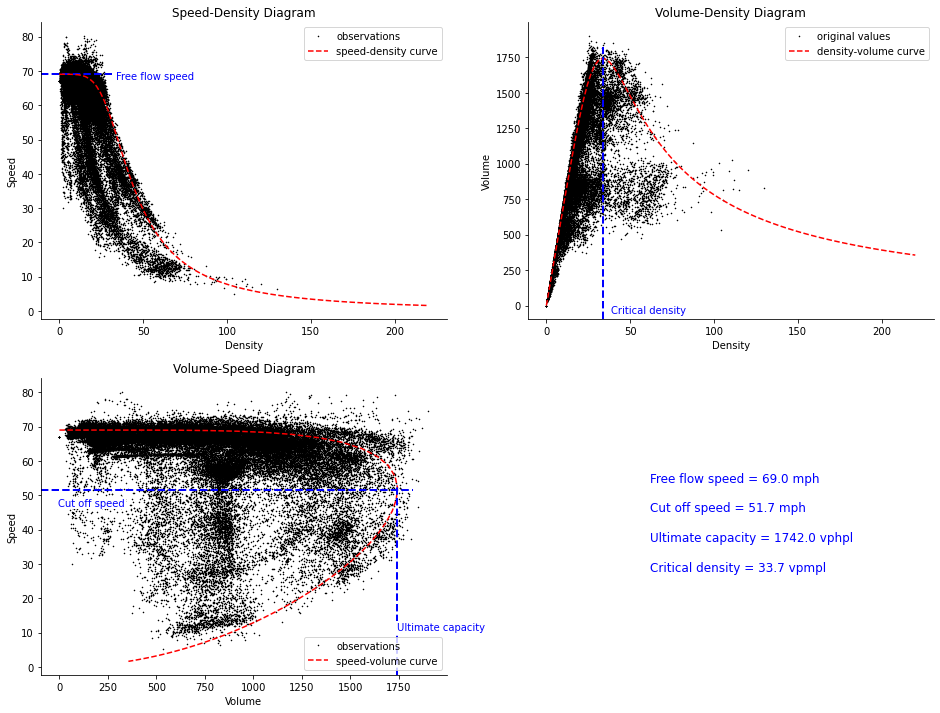

Calibrated diagrams for  Urban Business


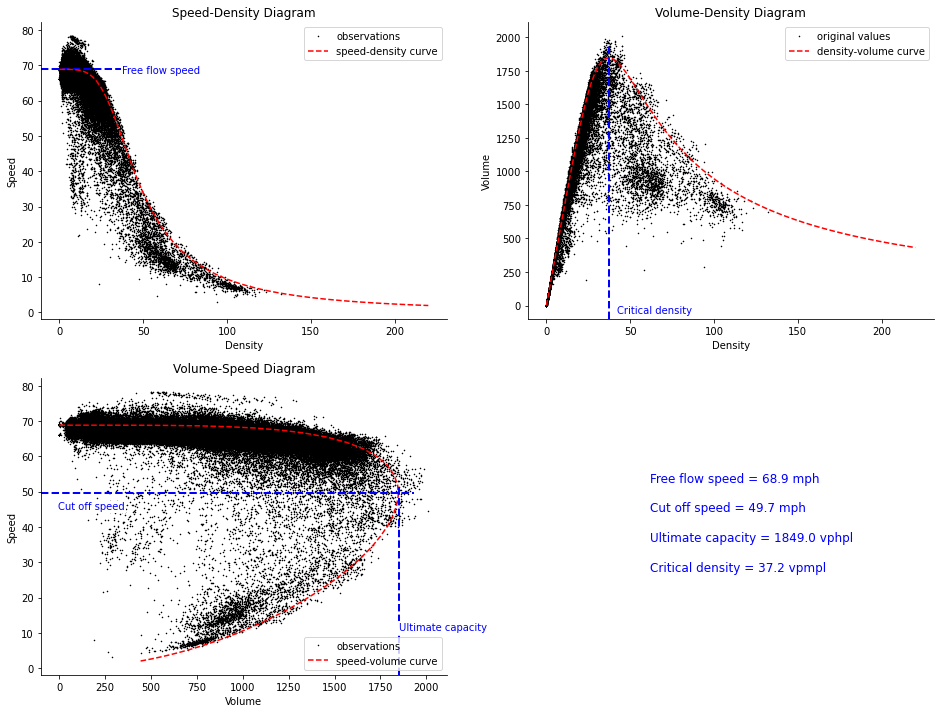

Calibrated diagrams for  Urban


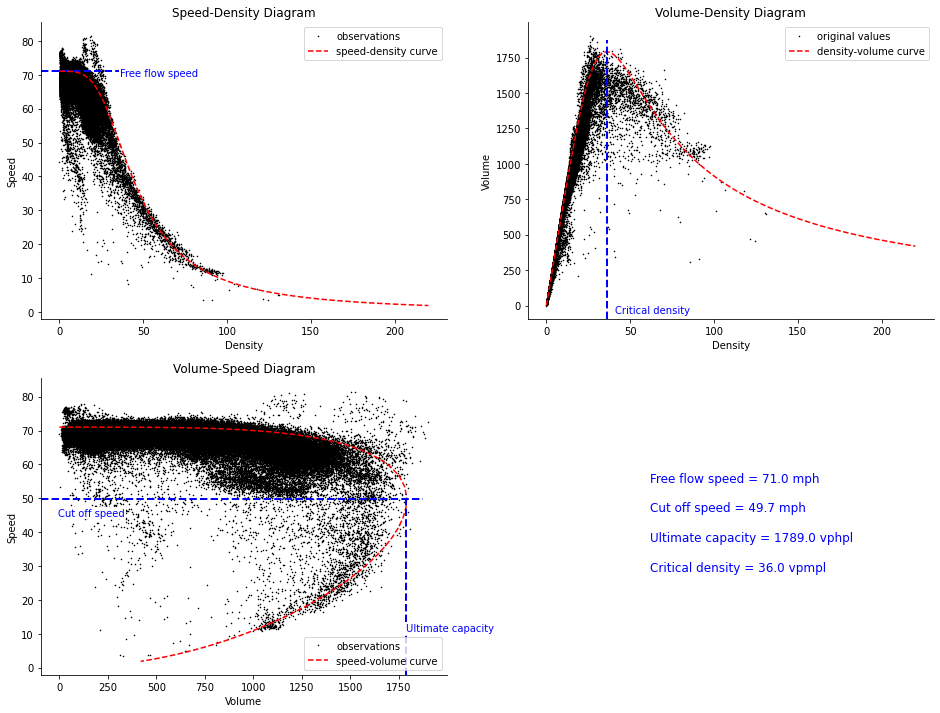

In [104]:
# By Area Types
mainline_paras = pd.DataFrame()
for at in area_types.keys():
    df_cal = sf_flow_speed_ml[(sf_flow_speed_ml['AT']==at)]
    if len(df_cal)>0:
        print('Calibrated diagrams for ', area_types[at])
        ft_speed_at_capacity,ft_ultimate_capacity,ft_critical_density,ft_free_flow_speed,ft_mm=_calibrate_traffic_flow_model(df_cal, 'Freeway_Mainline_AT' + str(at))
        df_cal['speed_at_capacity'] = ft_speed_at_capacity
        df_cal['ultimate_capacity'] = ft_ultimate_capacity
        df_cal['critical_density'] = ft_critical_density
        df_cal['free_flow_speed'] = ft_free_flow_speed
        df_cal['mm'] = ft_mm
        mainline_paras = mainline_paras.append(df_cal, ignore_index=True)

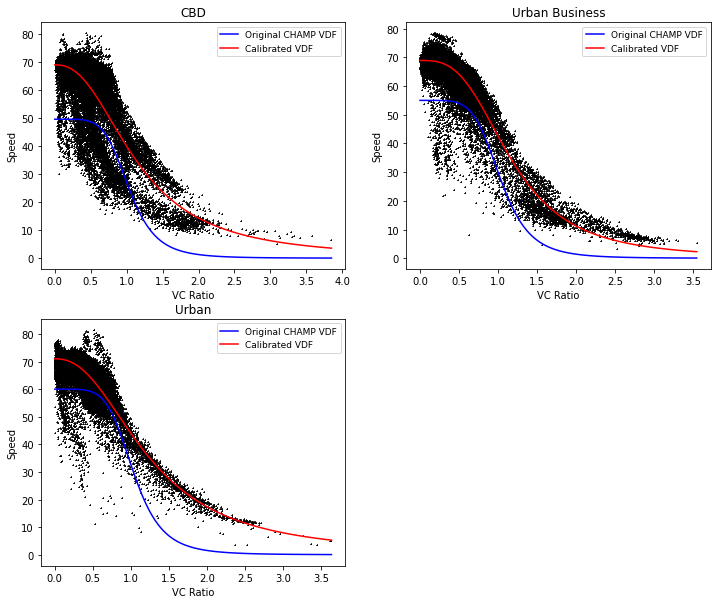

In [120]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))

mainline_paras['vcratio'] = mainline_paras['density']/mainline_paras['critical_density']
subid = 0
ml_vars = {}

#Original values from CHAMP
alpha0, beta0, rho0 = 0.83, 5.5, 1
p0 = [alpha0, beta0]  # initial parameters

#calibration bounds
lower_alpha, upper_alpha = 0.15, 10
lower_beta, upper_beta = 1.5, 10
lowerbound_fitting=[lower_alpha, lower_beta]
upperbound_fitting=[upper_alpha, upper_beta]

def _bpr_func1(x_vc, alpha, beta):  # input x_vc, alpha and beta to be calibrated
    return ffs_calib/(1+alpha*np.power(x_vc,beta))

for at in area_types.keys():
    df_cal = mainline_paras[(mainline_paras['AT']==at)]
    if len(df_cal)>0:
        x_demand_over_capacity = np.array(df_cal['vcratio'])
        y_speed = np.array(df_cal['speed'])

        ffs_champ = df_cal.SPEED.mean()
        ffs_calib = df_cal.free_flow_speed.mean()

        popt, pcov = curve_fit(_bpr_func1, x_demand_over_capacity, y_speed, p0, bounds=[lowerbound_fitting, upperbound_fitting], method='trf')
        alpha1, beta1 = popt

        vc_list = np.linspace(0, df_cal['vcratio'].max(),100)
        tt_list_org = [ffs_champ/rho0/(1 + alpha0*np.power(vc,beta0)) for vc in vc_list]
        tt_list_cal = [ffs_calib/(1 + alpha1*np.power(vc,beta1)) for vc in vc_list]

        row, col = subid//2, subid%2
        ax[row, col].scatter(x = df_cal['vcratio'], y = df_cal['speed'], c='black', marker='+', s = 1)
        ax[row, col].plot(vc_list, tt_list_org, c='blue', label='Original CHAMP VDF')
        ax[row, col].plot(vc_list, tt_list_cal, c='red', label='Calibrated VDF')
        ax[row, col].legend(loc='upper right', prop={'size': 9})
        ax[row, col].set_xlabel('VC Ratio')
        ax[row, col].set_ylabel('Speed')
        ax[row, col].set_title(area_types[at])

        cal_vars = [(alpha0, beta0), (round(alpha1,3), round(beta1,3))]
        ml_vars[at] = cal_vars

        subid += 1
        
        ax[-1, -1].axis('off')
#plt.savefig(os.path.join(vdf_dir, 'Freeway_Mainline_Calibration.png'), bbox_inches='tight')

In [121]:
ml_vars

{1: [(0.83, 5.5), (0.727, 2.393)],
 2: [(0.83, 5.5), (0.618, 3.047)],
 3: [(0.83, 5.5), (0.611, 2.331)]}

### Ramps 

#### Overall  

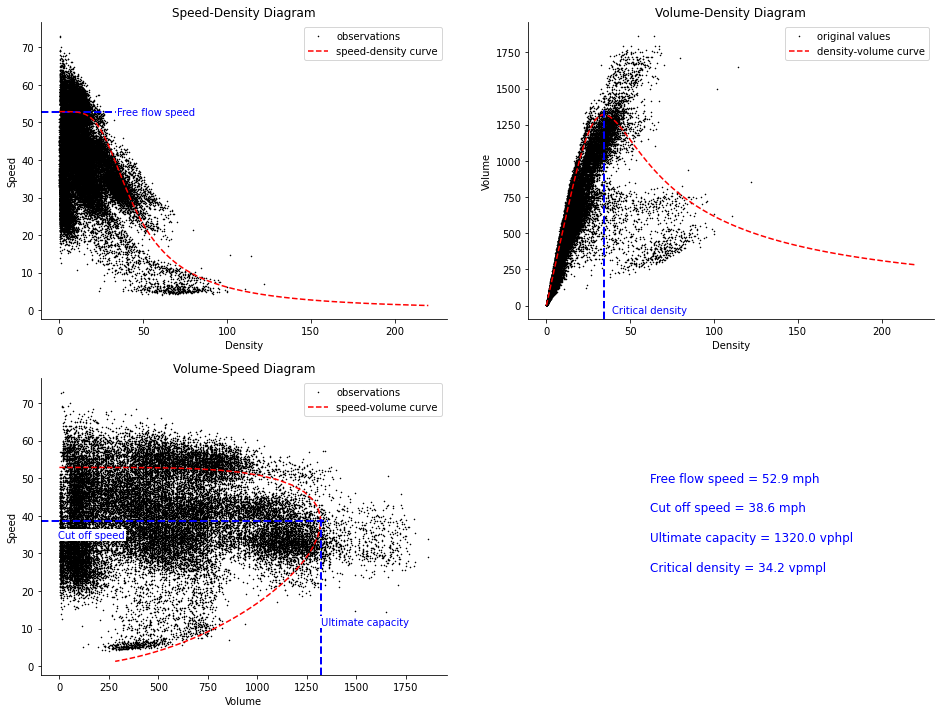

38.6 1320.0 34.2 52.9 4.39


In [107]:
ramp_speed_at_capacity,ramp_ultimate_capacity,ramp_critical_density,ramp_free_flow_speed,ramp_mm=_calibrate_traffic_flow_model(sf_flow_speed_ramp_inrix, 'Freeway_Ramps')
print(ramp_speed_at_capacity,ramp_ultimate_capacity,ramp_critical_density,ramp_free_flow_speed,ramp_mm)

0.83 5.5
0.823 1.5


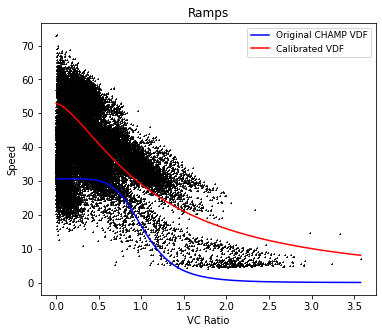

In [108]:
# Use FFS calibrated from above diagrams
fig, ax = plt.subplots(1, 1, figsize=(6,5))
subid = 0
df_cal= sf_flow_speed_ramp_inrix.copy()
df_cal['vcratio'] = df_cal['density']/ramp_critical_density
x_demand_over_capacity = np.array(df_cal['vcratio'])
y_speed = np.array(df_cal['speed'])

ffs_champ = df_cal.SPEED.mean()
ffs_calib = ramp_free_flow_speed

#calibration bounds
lower_alpha, upper_alpha = 0.15, 5
lower_beta, upper_beta = 1.5, 10

alpha0, beta0, rho0 = 0.83, 5.5, 1

# two parameter
lowerbound_fitting=[lower_alpha, lower_beta]
upperbound_fitting=[upper_alpha, upper_beta]
p0 = [alpha0, beta0]  # initial two parameters
def _bpr_func1(x, alpha, beta):
    return ffs_calib/(1+alpha*np.power(x,beta))

popt, pcov = curve_fit(_bpr_func1, x_demand_over_capacity, y_speed, p0, bounds=[lowerbound_fitting, upperbound_fitting], method='trf')
alpha1, beta1 = popt

print(alpha0, beta0)
print(round(alpha1,3), round(beta1,3))

vc_list = np.linspace(0, df_cal['vcratio'].max(),100)
tt_list_org = [ffs_champ/rho0/(1 + alpha0*np.power(vc,beta0)) for vc in vc_list]
tt_list_cal = [ffs_calib/(1 + alpha1*np.power(vc,beta1)) for vc in vc_list]

ax.scatter(x = df_cal['vcratio'], y = df_cal['speed'], c='black', marker='+', s = 1)
ax.plot(vc_list, tt_list_org, c='blue', label='Original CHAMP VDF')
ax.plot(vc_list, tt_list_cal, c='red', label='Calibrated VDF')
ax.legend(loc='upper right', prop={'size': 9})
ax.set_xlabel('VC Ratio')
ax.set_ylabel('Speed')
ax.set_title('Ramps')
plt.show()

#### By Area Types 

Calibrated diagrams for  Urban Business


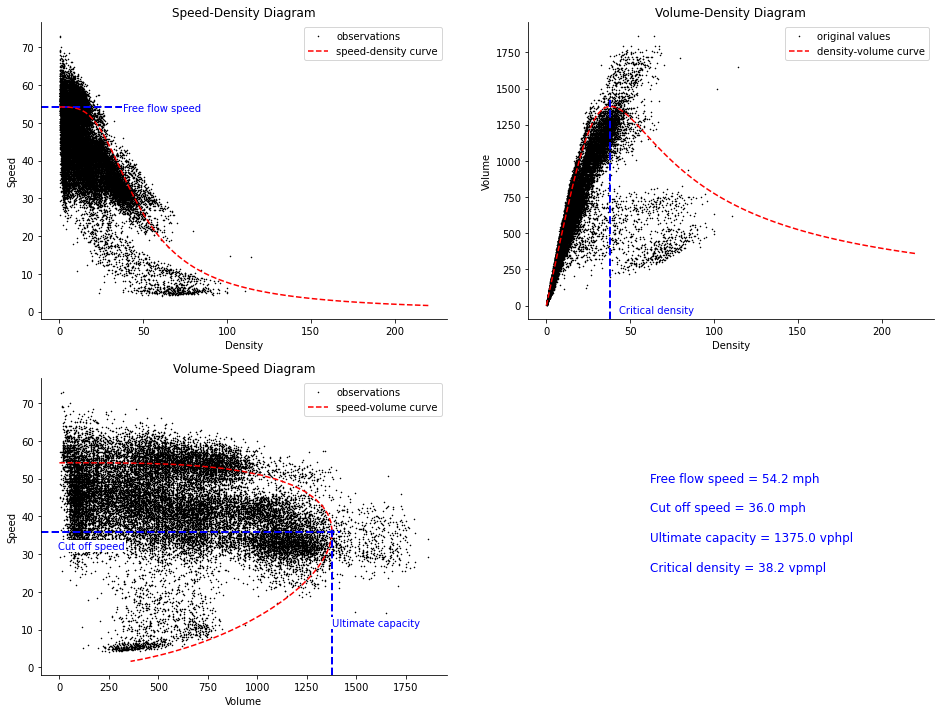

Calibrated diagrams for  Urban


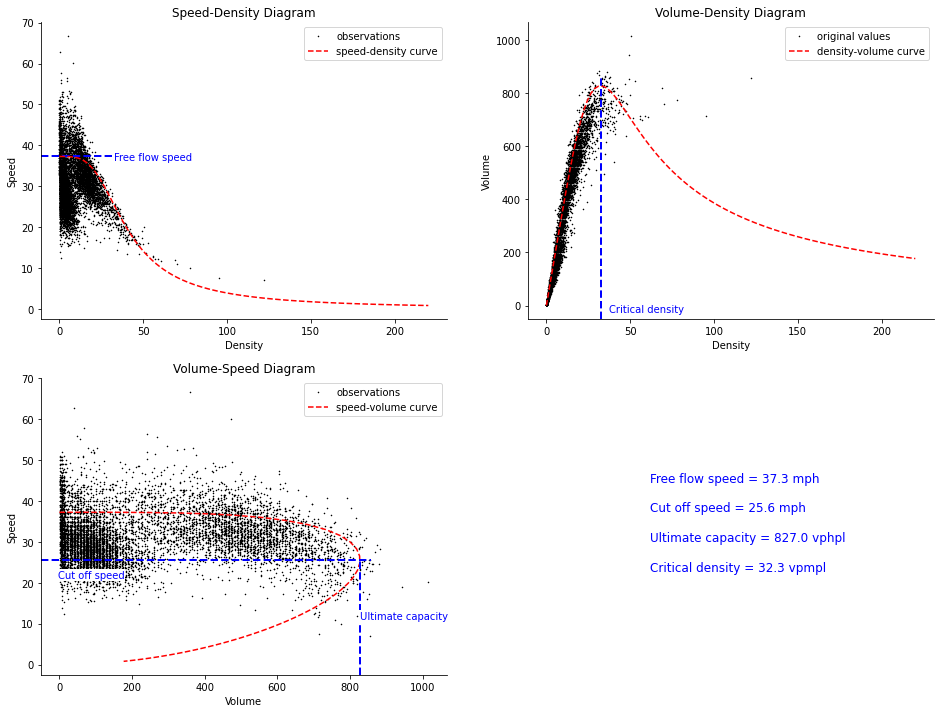

In [109]:
# By Area Types
ramp_paras = pd.DataFrame()
for at in area_types.keys():
    df_cal = sf_flow_speed_ramp_inrix[(sf_flow_speed_ramp_inrix['AT']==at)]
    if len(df_cal)>0:
        print('Calibrated diagrams for ', area_types[at])
        ft_speed_at_capacity,ft_ultimate_capacity,ft_critical_density,ft_free_flow_speed,ft_mm=_calibrate_traffic_flow_model(df_cal, 'Freeway_Ramps_AT' + str(at))
        df_cal['speed_at_capacity'] = ft_speed_at_capacity
        df_cal['ultimate_capacity'] = ft_ultimate_capacity
        df_cal['critical_density'] = ft_critical_density
        df_cal['free_flow_speed'] = ft_free_flow_speed
        df_cal['mm'] = ft_mm
        ramp_paras = ramp_paras.append(df_cal, ignore_index=True)

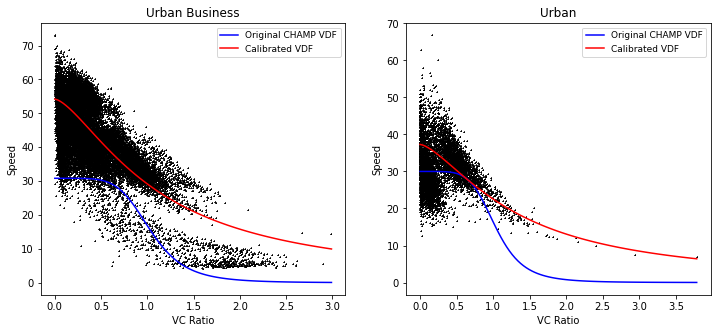

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ramp_paras['vcratio'] = ramp_paras['density']/ramp_paras['critical_density']
subid = 0
ramp_vars = {}

#Original values from CHAMP
alpha0, beta0, rho0 = 0.83, 5.5, 1
p0 = [alpha0, beta0]  # initial parameters

#calibration bounds
lower_alpha, upper_alpha = 0.15, 10
lower_beta, upper_beta = 1.5, 10
lowerbound_fitting=[lower_alpha, lower_beta]
upperbound_fitting=[upper_alpha, upper_beta]

def _bpr_func1(x_vc, alpha, beta):  # input x_vc, alpha and beta to be calibrated
    return ffs_calib/(1+alpha*np.power(x_vc,beta))

for at in area_types.keys():
    df_cal = ramp_paras[(ramp_paras['AT']==at)]
    if len(df_cal)>0:
        x_demand_over_capacity = np.array(df_cal['vcratio'])
        y_speed = np.array(df_cal['speed'])

        ffs_champ = df_cal.SPEED.mean()
        ffs_calib = df_cal.free_flow_speed.mean()

        popt, pcov = curve_fit(_bpr_func1, x_demand_over_capacity, y_speed, p0, bounds=[lowerbound_fitting, upperbound_fitting], method='trf')
        alpha1, beta1 = popt

        vc_list = np.linspace(0, df_cal['vcratio'].max(),100)
        tt_list_org = [ffs_champ/rho0/(1 + alpha0*np.power(vc,beta0)) for vc in vc_list]
        tt_list_cal = [ffs_calib/(1 + alpha1*np.power(vc,beta1)) for vc in vc_list]

        col = subid%2
        ax[col].scatter(x = df_cal['vcratio'], y = df_cal['speed'], c='black', marker='+', s = 1)
        ax[col].plot(vc_list, tt_list_org, c='blue', label='Original CHAMP VDF')
        ax[col].plot(vc_list, tt_list_cal, c='red', label='Calibrated VDF')
        ax[col].legend(loc='upper right', prop={'size': 9})
        ax[col].set_xlabel('VC Ratio')
        ax[col].set_ylabel('Speed')
        ax[col].set_title(area_types[at])

        cal_vars = [(alpha0, beta0), (round(alpha1,3), round(beta1,3))]
        ramp_vars[at] = cal_vars

        subid += 1
#plt.savefig(os.path.join(vdf_dir, 'Freeway_Ramp_Calibration.png'), bbox_inches='tight')

In [111]:
ramp_vars

{2: [(0.83, 5.5), (0.859, 1.5)], 3: [(0.83, 5.5), (0.654, 1.5)]}